In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



# 1. Overview

# 2. Reconstruction of single $\mu$

## 2.1 Setup

### Simulation

Simulation uses muon gun generator to generate mono-energetic $\mu$ events. The muon gun is located at 2 m below the center of one detector module. The muon spread angle is set to guarantee that the track passes through all layers in this same module, avoiding the gap between modules.

* Script: ./scripts/muon_gun_tom_range.mac
* Muon energy used: 1 2 5 10 50 100 1000  
* Events (per energy): 200
    
### Tracker    

Events are reconstructed with the tracker using default tracker parameters (git 1712f69). For each simulation, the tracker is repeated 200 times. 
    
Command to run the simulation and tracker once (example):    

    simulation -j2 -o ../fit_study/data/muon_500_GeV -q -s ../fit_study/muon_gun_tom_debug.mac energy 500 count 10
    tracker ../.fit_study/data/muon_500_GeV/20230127/175313/run0.root ../fit_study/data/muon_500_GeV/20230127/175313
    
Script to run all simulations and reconstructions:

    ./scripts/run_all.sh


In [3]:
energy_list = [1, 2, 5, 10, 50, 100, 1000]
# energy_list = [1]


results={}
for muon_energy in energy_list:
    print("Processing energy ",muon_energy, "GeV")
    
    data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
    files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
    files=util.Utils.sortByExt(files)
    
    tfile = root.TFile.Open(files[0])
    Tree = tfile.Get("integral_tree")
    nevents = int(Tree.GetEntries())    

    truth=[]
    recon=[]
    recon_unc=[]
    ievent=[]
    ifile=[]
    ndigi=np.zeros(nevents)
    n_events=np.zeros(nevents)
    n_failed=np.zeros(nevents)

    for i,filename in enumerate(tqdm(files)):
        tfile = root.TFile.Open(filename)
        tree_name = ["integral_tree","box_run"][0]
        Tree = tfile.Get(tree_name)

        for Entry in range(nevents):
            Tree.GetEntry(Entry)
            try:
#             if 1:
                n_events[Entry]+=1
                ndigi[Entry]=len(Tree.Digi_x)
        
                recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0],Tree.Track_k_m_velZ[0], Tree.Track_k_m_velX[0], Tree.Track_k_m_velY[0]])
                recon_unc.append([Tree.Track_k_m_ErrorZ0[0], Tree.Track_k_m_ErrorX0[0], Tree.Track_k_m_ErrorY0[0], Tree.Track_k_m_ErrorT0[0],Tree.Track_k_m_ErrorVz[0], Tree.Track_k_m_ErrorVx[0], Tree.Track_k_m_ErrorVy[0]])
                truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
                ievent.append(Entry)
                ifile.append(i)
            except:
                n_failed[Entry]+=1
                
    results[muon_energy]={
        "truth":np.array(truth),
        "recon":np.array(recon),
        "recon_unc":np.array(recon_unc),
        "ievent":np.array(ievent),
        "ifile":np.array(ifile),
        "ndigi":np.array(ndigi),
        "n_events":n_events,
        "n_failed":n_failed
    }

Processing energy  1 GeV


100%|██████████| 200/200 [00:13<00:00, 15.34it/s]


Processing energy  2 GeV


100%|██████████| 200/200 [00:13<00:00, 14.70it/s]


Processing energy  5 GeV


100%|██████████| 200/200 [00:12<00:00, 16.20it/s]


Processing energy  10 GeV


100%|██████████| 200/200 [00:12<00:00, 16.45it/s]


Processing energy  50 GeV


100%|██████████| 200/200 [00:12<00:00, 15.75it/s]


Processing energy  100 GeV


100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


Processing energy  1000 GeV


100%|██████████| 200/200 [00:13<00:00, 14.45it/s]


In [4]:
# gdiv = TGraphAsymmErrors()
# chi_mask=dict()

# gdiv.Divide(h1, h0, "c1=0.683 b(1,1) mode");
# gdiv.Draw()


Energy 1 GeV
  32561.0/40000.0 events with Kalman Filter reconstruction (0.814+/- 0.0493)
Energy 2 GeV
  32678.0/40000.0 events with Kalman Filter reconstruction (0.817+/- 0.0524)
Energy 5 GeV
  32884.0/40000.0 events with Kalman Filter reconstruction (0.822+/- 0.0455)
Energy 10 GeV
  32649.0/40000.0 events with Kalman Filter reconstruction (0.816+/- 0.0452)
Energy 50 GeV
  33067.0/40000.0 events with Kalman Filter reconstruction (0.827+/- 0.0538)
Energy 100 GeV
  32933.0/40000.0 events with Kalman Filter reconstruction (0.823+/- 0.0545)
Energy 1000 GeV
  33275.0/40000.0 events with Kalman Filter reconstruction (0.832+/- 0.0666)


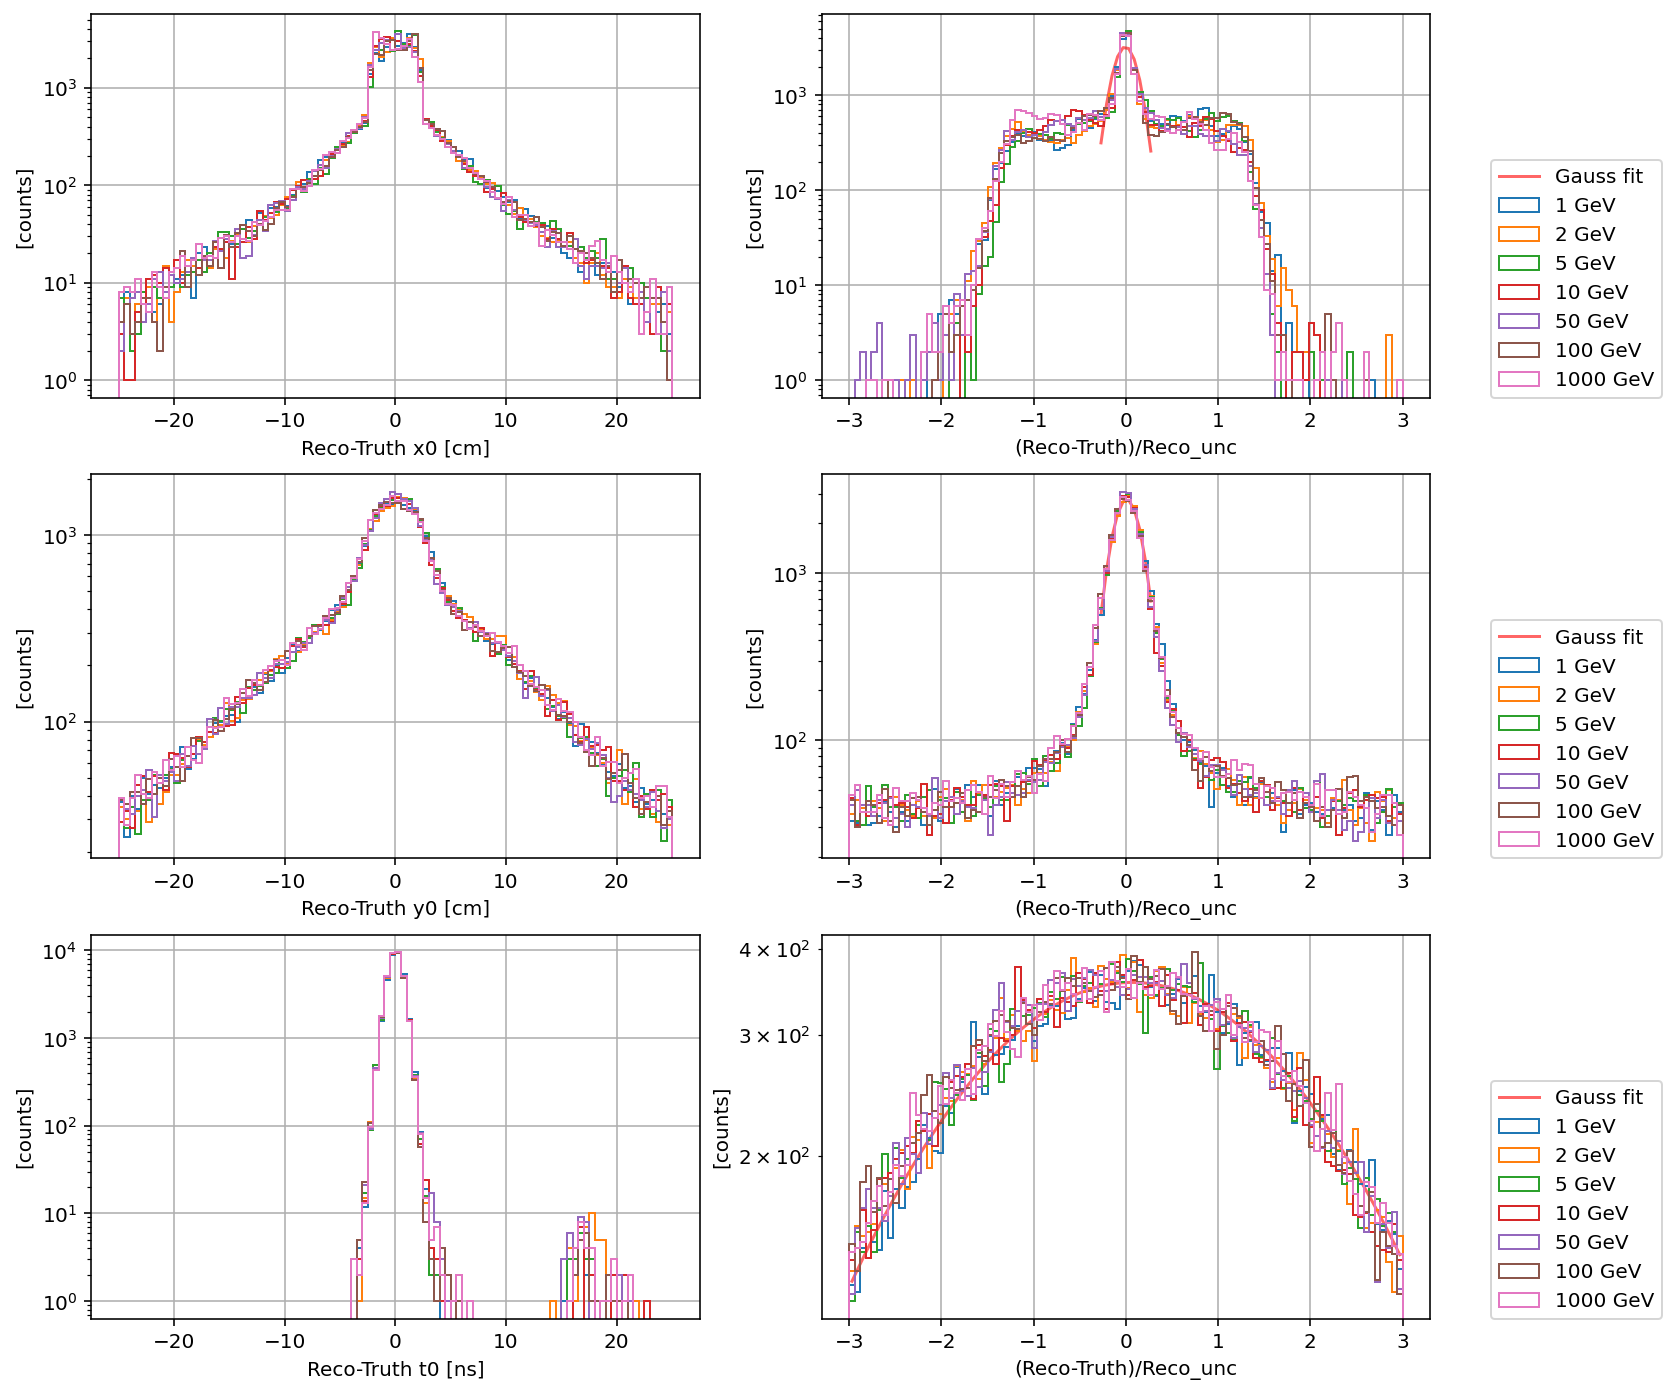

(0.0, 1.0)


  RooFitResult: minimized FCN value: -153970, estimated distance to minimum: 6.61276e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
            Gaussian_a    1.6304e+04 +/-  1.28e+02
           Gaussian_p0   -5.5141e-03 +/-  1.01e-03
           Gaussian_p1    1.2255e-01 +/-  8.43e-04


  RooFitResult: minimized FCN value: -160302, estimated distance to minimum: 1.14694e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
            Gaussian_a    1.7108e+04 +/-  1.31e+02
           Gaussian_p0    8.3688e-03 +/-  1.39e-03
           Gaussian_p1    1.5623e-01 +/-  1.40e-03


  RooFitResult: minimized FCN value: -199807, estimated distanc

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBranch::Fill>: Failed to write out basket.

Error in <TBranch::WriteBasketImpl>: basket's WriteBuffer failed.
Error in <TBranch::TBran

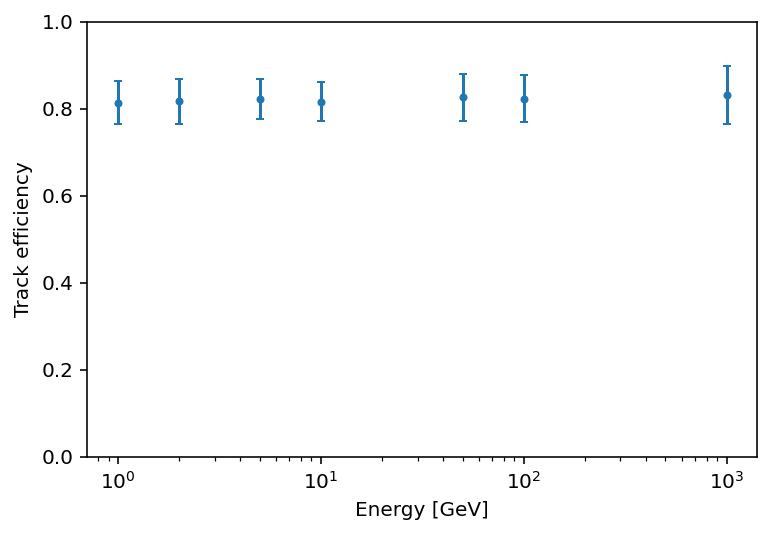

In [164]:
def pull(x_measure, x_truth, x_unc):
    return (x_measure-x_truth)/x_unc

def poissonerror_div(N1,N2):
    return np.sqrt(1/N1+1/N2)*N1/N2


track_efficiency=[]
fig,axs=plt.subplots(3,2,figsize=(12,12))
for muon_energy in energy_list:

    ndigi=np.array(results[muon_energy]["ndigi"])
        
    recon=np.array(results[muon_energy]["recon"])
    recon_unc=np.array(results[muon_energy]["recon_unc"])
    truth=np.array(results[muon_energy]["truth"])
    
    n_events=results[muon_energy]["n_events"]
    n_failed=results[muon_energy]["n_failed"]
    
    axlabels=["x0 [cm]","y0 [cm]", "t0 [ns]"]
    ind=[0,1,3]
    fit_ranges=[[-0.3,0.3],
                [-0.3,0.3],
                [-3,3]]
    fit_bins=[10,10,100]
    
    for i in [0,1,2]:
        axs[i][0].hist(recon[:,ind[i]]-truth[:,ind[i]],bins=100,range=(-25,25),histtype="step",label=f"{muon_energy} GeV");
        axs[i][0].set_xlabel(f"Reco-Truth {axlabels[i]}")
        axs[i][0].set_ylabel("[counts]")
        axs[i][0].set_yscale("log")
        axs[i][0].grid()

        recon_pull = pull(recon[:,ind[i]],truth[:,ind[i]], recon_unc[:, ind[i]])      
        if muon_energy==1:
            x,y, popt,perr = util.Utils.fitu(recon_pull, fit_range=fit_ranges[i], n_bins=fit_bins[i], functions=(root.RooGaussian,),
                        initial_values=((np.mean(recon_pull),np.std(recon_pull), len(recon_pull)/np.std(recon_pull)),),
                        bounds=(((-1e6, 1e6), (0, 1e6), (0, 1e6)), ),
                        set_constant=None,
                        verbosity=0)   
            axs[i][1].plot(x,y,color="r",alpha=0.6,label="Gauss fit")        
        axs[i][1].hist(recon_pull,bins=100,range=(-3,3),histtype="step",label=f"{muon_energy} GeV");
        axs[i][1].set_xlabel("(Reco-Truth)/Reco_unc")
        axs[i][1].set_ylabel("[counts]")
        axs[i][1].set_yscale("log")
        axs[i][1].grid()
        axs[i][1].legend(loc=(1.1,0))  
                
    fraction = (n_events-n_failed)/n_events
    # unc=poissonerror_div(n_events-n_failed,n_events)
    trackeff=np.mean(fraction)
    trackunc=np.std(fraction)
    track_efficiency.append([muon_energy, trackeff, trackunc])
    print(f"Energy {muon_energy} GeV\n  {sum(n_events)-sum(n_failed)}/{sum(n_events)} events with Kalman Filter reconstruction ({trackeff:.3}+/-{trackunc: .3})")   
    #plt.plot(fraction)
    #plt.show()
plt.show()
    
track_efficiency=np.transpose(track_efficiency)
plt.errorbar(track_efficiency[0],track_efficiency[1],yerr=track_efficiency[2],fmt=".", capsize=2)
plt.xlabel("Energy [GeV]")
plt.ylabel("Track efficiency")
plt.xscale("log")
plt.ylim(0,1)

## Track efficiency of one energy, with cuts

In [3]:
muon_energy=100
print("Processing energy ",muon_energy, "GeV")

data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)

tfile = root.TFile.Open(files[0])
Tree = tfile.Get("integral_tree")
nevents = int(Tree.GetEntries())   

truth=[]
recon=[]
recon_unc=[]
ievent=[]
ifile=[]
ndigi=np.zeros(nevents)
n_events=np.zeros(nevents)
n_failed=np.zeros(nevents)

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)

    for Entry in range(nevents):
        Tree.GetEntry(Entry)
        try:
#             if 1:
            n_events[Entry]+=1
            ndigi[Entry]=len(Tree.Digi_x)
        
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0],Tree.Track_k_m_velZ[0], Tree.Track_k_m_velX[0], Tree.Track_k_m_velY[0]])
            ievent.append(Entry)
            ifile.append(i)
            
            recon_unc.append([Tree.Track_k_m_ErrorZ0[0], Tree.Track_k_m_ErrorX0[0], Tree.Track_k_m_ErrorY0[0], Tree.Track_k_m_ErrorT0[0],Tree.Track_k_m_ErrorVz[0], Tree.Track_k_m_ErrorVx[0], Tree.Track_k_m_ErrorVy[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])

        except:
            n_failed[Entry]+=1

truth=np.array(truth)
recon=np.array(recon)
recon_unc=np.array(recon_unc)
ievent=np.array(ievent)
ifile=np.array(ifile)
ndigi=np.array(ndigi)


Processing energy  100 GeV


100%|██████████| 200/200 [00:17<00:00, 11.45it/s]


Text(0, 0.5, 'counts')

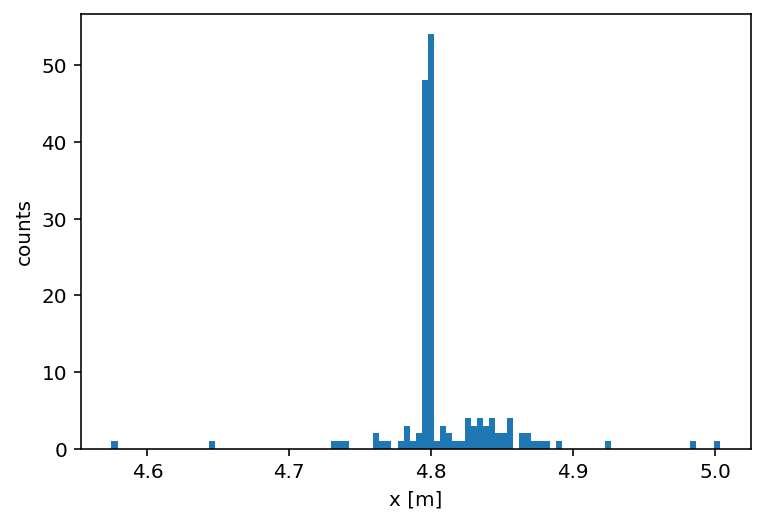

In [6]:
plt.hist(recon[:,0][ievent==6]/100-119.5,bins=100);
plt.xlabel("x [m]")
plt.ylabel('counts')

Energy 100 GeV
  32933.0/40000.0 events with Kalman Filter reconstruction (0.823+/- 0.0545)


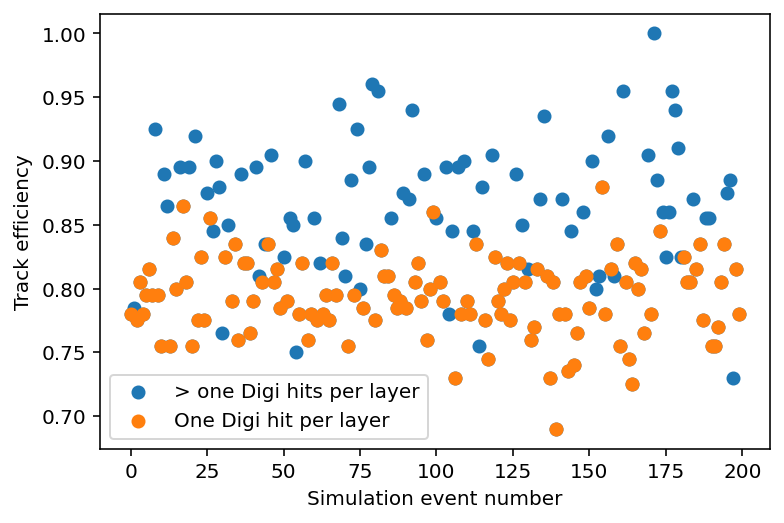

In [163]:
fraction = (n_events-n_failed)/n_events
mask = ndigi==7
inds=np.arange(len(fraction))

trackeff=np.mean(fraction)
trackunc=np.std(fraction)
print(f"Energy {muon_energy} GeV\n  {sum(n_events)-sum(n_failed)}/{sum(n_events)} events with Kalman Filter reconstruction ({trackeff:.3}+/-{trackunc: .3})")   



plt.scatter(inds,fraction,label="> one Digi hits per layer")
plt.scatter(inds[mask],fraction[mask],color="C1",label="One Digi hit per layer")
plt.xlabel("Simulation event number")
plt.ylabel("Track efficiency")
plt.legend()

In [ ]:
# gdiv = TGraphAsymmErrors()
# chi_mask=dict()

# gdiv.Divide(h1, h0, "c1=0.683 b(1,1) mode");
# gdiv.Draw()


### Least square fit

In [59]:
#### Tree.Digi_py[1]

99785.65459188934

In [150]:
hits[0].x_uncertainty

14.13235200002555

In [21]:
# Least-square fit?
# First try, using 'x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'
import iminuit
from iminuit import Minuit, cost
import cutflow,detector
det=detector.Detector()

class Hit:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z
        self.t=t
        self.t_uncertainty=1
        # Get the layer-dependent uncertainty of each hit
        cut=cutflow.sample_space("")
        self.hit_layer=cut.in_layer(y)
        hit_uncertainty = np.array(detector.Layer().uncertainty(self.hit_layer))
        self.x_uncertainty=hit_uncertainty[0]*100 # m->cm
        self.z_uncertainty=hit_uncertainty[2]*100 # m->cm
        
        
class chi2_track:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            model_t = (hit.y - y0)/vy
            model_x = x0 + model_t*vx
            model_z = z0 + model_t*vz
            error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
                                     (model_x-hit.x)/hit.x_uncertainty, 
                                     (model_z-hit.z)/hit.z_uncertainty],2))
        return error        
        
def get_digi_hits(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    hits=[]
    for ii in range(len(ev.Tree.Digi_y)):
        hit=Hit(ev.Tree.Digi_x[ii], ev.Tree.Digi_y[ii], ev.Tree.Digi_z[ii], ev.Tree.Digi_time[ii])
        hits.append(hit)
    return hits

def guess_track(hits):
    # Guess initial value
    x0_init = hits[0].x
    y0_init = hits[0].y
    z0_init = hits[0].z
    t0_init = hits[0].t
    dt=hits[1].t-hits[0].t
    vx_init = (hits[1].x-hits[0].x)/dt
    vy_init = (hits[1].y-hits[0].y)/dt
    vz_init = (hits[1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>sp.constants.c*1e-7:
        vx_init = vx_init*0.99*sp.constants.c*1e-7/v_mod
        vy_init = vy_init*0.99*sp.constants.c*1e-7/v_mod
        vz_init = vz_init*0.99*sp.constants.c*1e-7/v_mod
    return  (x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init)
    
def fit_track(hits, guess):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess
    
    m = Minuit(chi2_track(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["y0"]=True
    m.limits["x0"]=(det.BoxLimits[0][0],det.BoxLimits[0][1])
    m.limits["z0"]=(det.BoxLimits[2][0],det.BoxLimits[2][1])
    m.limits["t0"]=(0,1e5)
    m.limits["vx"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Other
    m.limits["vy"]=(-sp.constants.c*1e-7,0) if vy_init<0 else (0,sp.constants.c*1e-7) # Constrain the direction in Z(up) in real world
    m.limits["vz"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.3
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.1
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    

    
    return m

def fit_track_scipy(hits, guess):
    # Using scipy?
    bounds=[]
    bounds.append((det.BoxLimits[0][0],det.BoxLimits[0][1]))
    bounds.append((det.BoxLimits[2][0],det.BoxLimits[2][1]))
    bounds.append((0,1e10))
    bounds.append((-sp.constants.c*1e-7, sp.constants.c*1e-7))
    lim_vy=(-sp.constants.c*1e-7,0) if guess[-2]<0 else (0,sp.constants.c*1e-7) # Constrain the direction in Z(up) in real world
    bounds.append(lim_vy)
    bounds.append((-sp.constants.c*1e-7, sp.constants.c*1e-7)) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7    
    
    def ls(par): 
        return chi2_track(hits)(par[0], guess[1], *par[1:])
    guess_no_y=guess[:1]+guess[2:]
    res = sp.optimize.minimize(ls, x0=guess_no_y,method="powell",bounds=bounds)  
    
    return res



ev = event.Event(files[0],4, tree_name="integral_tree")
# ev.EventNumber=5
hits = get_digi_hits(ev)

print(len(ev.Tree.Digi_x))
guess=guess_track(hits)
print("initial", guess)
fit1=fit_track(hits,guess)
fit2=fit_track_scipy(hits,guess)
fit1,fit2

7
initial (430.93847758840906, 8551.5, 12479.25, 7.389083959540979, 2.3823810920698265, 29.523502474226245, 4.121491683853087)


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


(┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.3                       │              Nfcn = 358              │
│ EDM = 2.17e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [22]:
list(fit1.values)

[441.61038446321487,
 8551.5,
 12479.476900959573,
 6.886394243400863,
 -0.7470622989004014,
 29.427667334722784,
 3.92133817244319]

In [199]:
# Tree=ev.Tree
# for i in range(len(Tree.Digi_numHits)):
#     print(Tree.Digi_time[i], Tree.Digi_x[i], Tree.Digi_y[i],Tree.Digi_z[i], Tree.Digi_particle_energy[i], Tree.Digi_pdg_id[i], Tree.Digi_seed)

In [200]:
# Tree=ev.Tree
# for i in range(int(Tree.NumHits)):
#     print(int(Tree.Hit_G4ParentTrackId[i]), Tree.Hit_particlePdgId[i], Tree.Hit_G4TrackId[i], Tree.Hit_x[i], Tree.Hit_y[i], Tree.Hit_z[i], Tree.Hit_energy[i], Tree.Hit_time[i])


## Let's fit one file

  0%|          | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  2


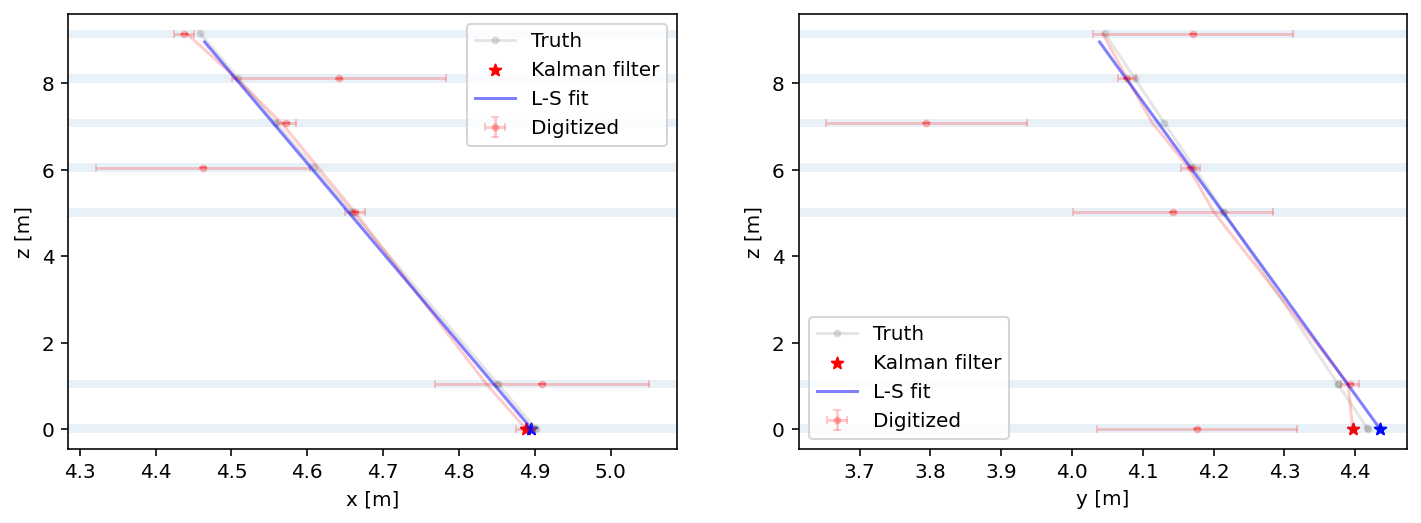

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  3


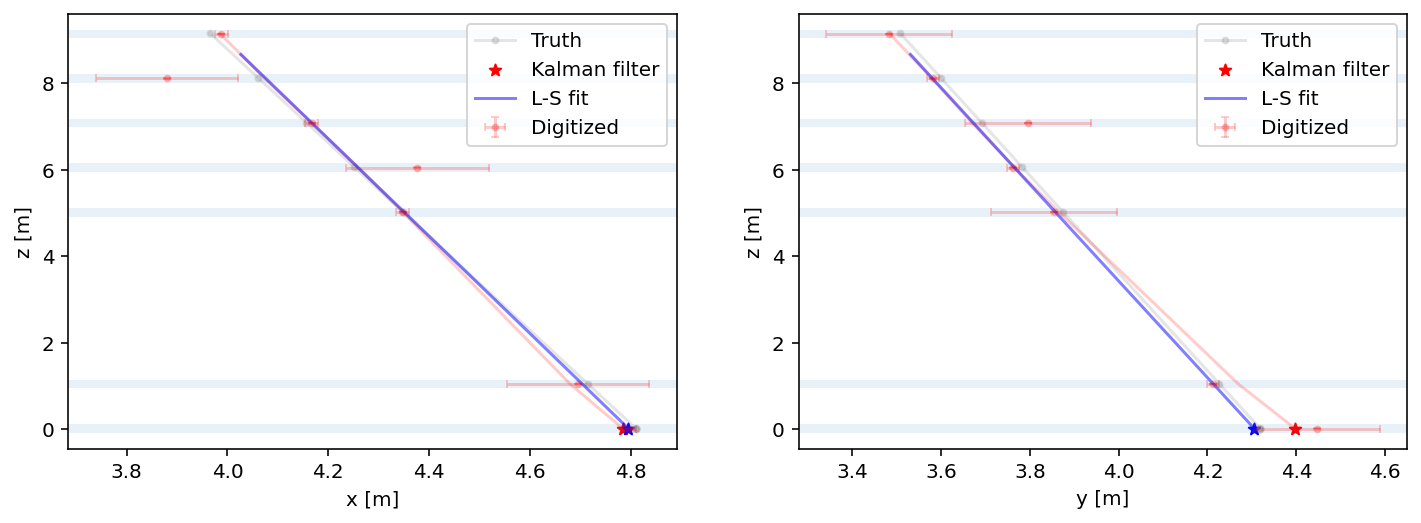

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  4


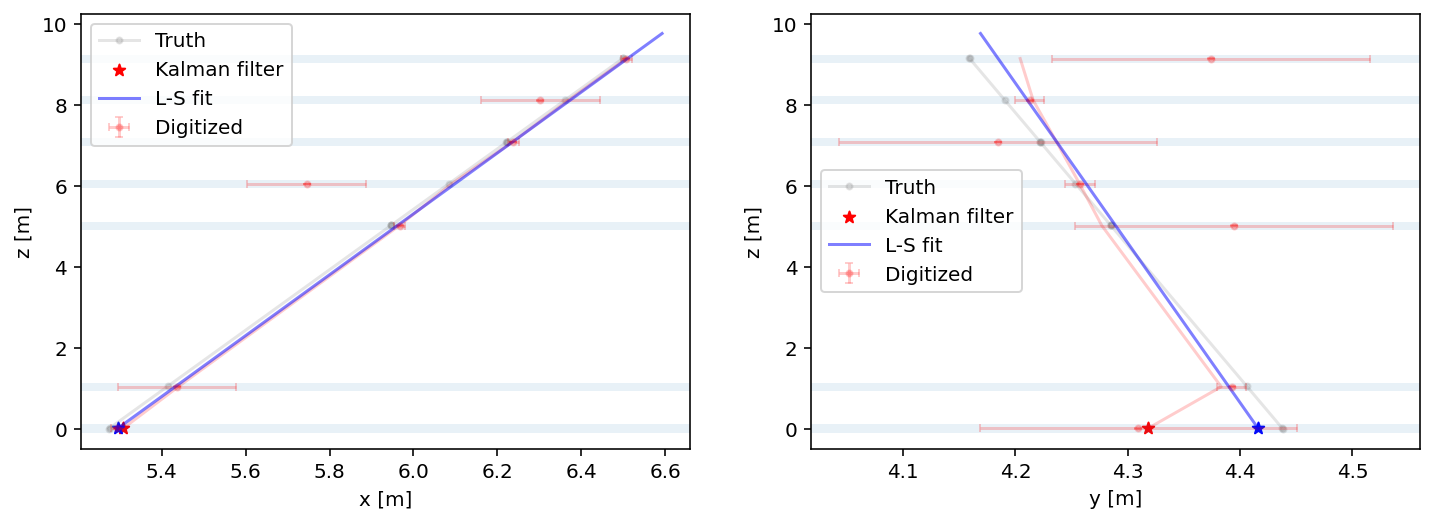

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  5


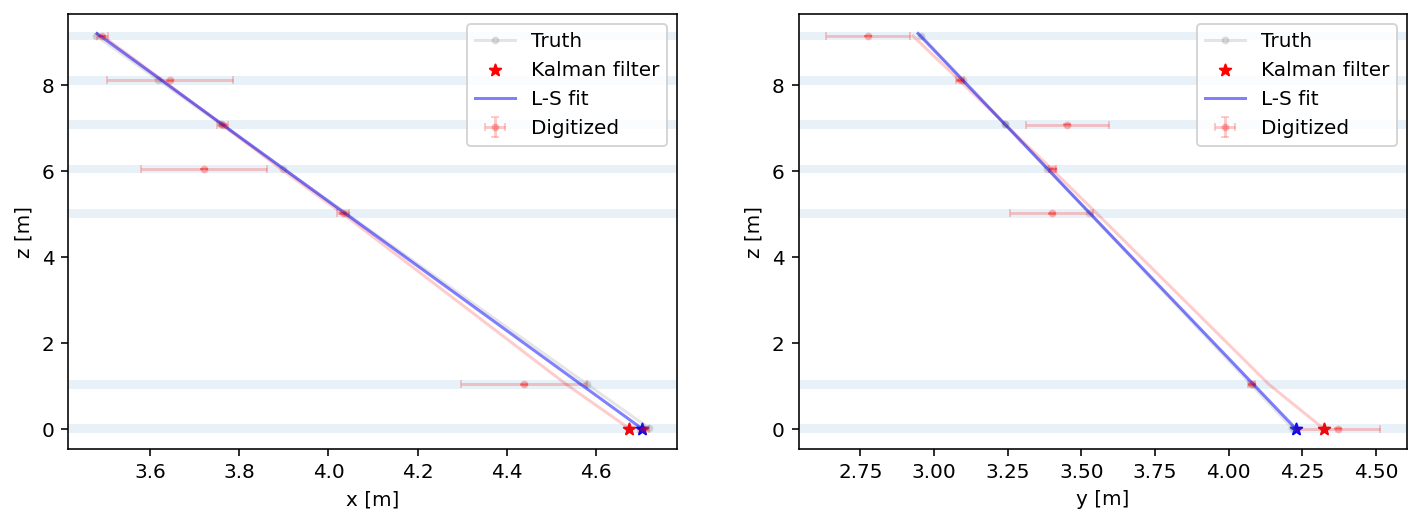

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  6


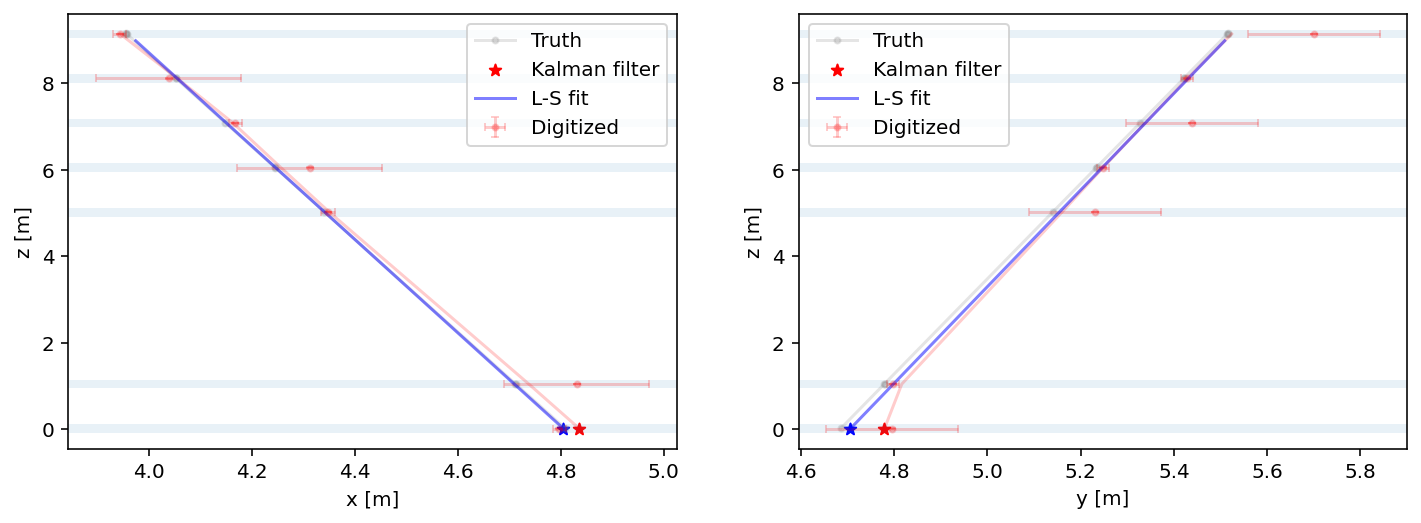

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  7


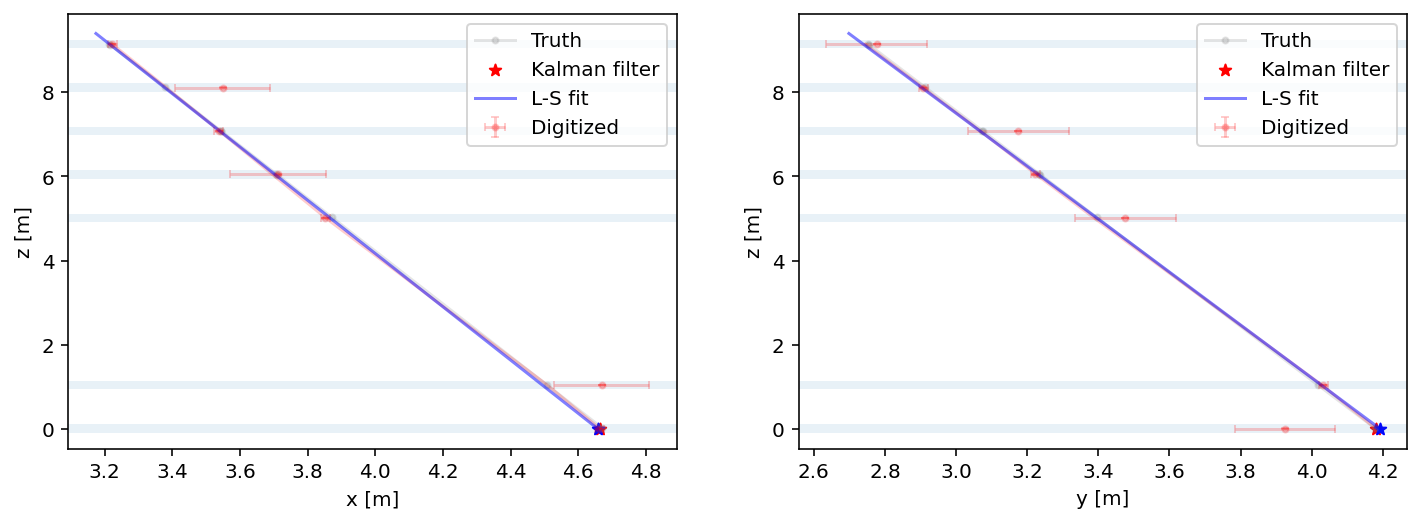

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  9


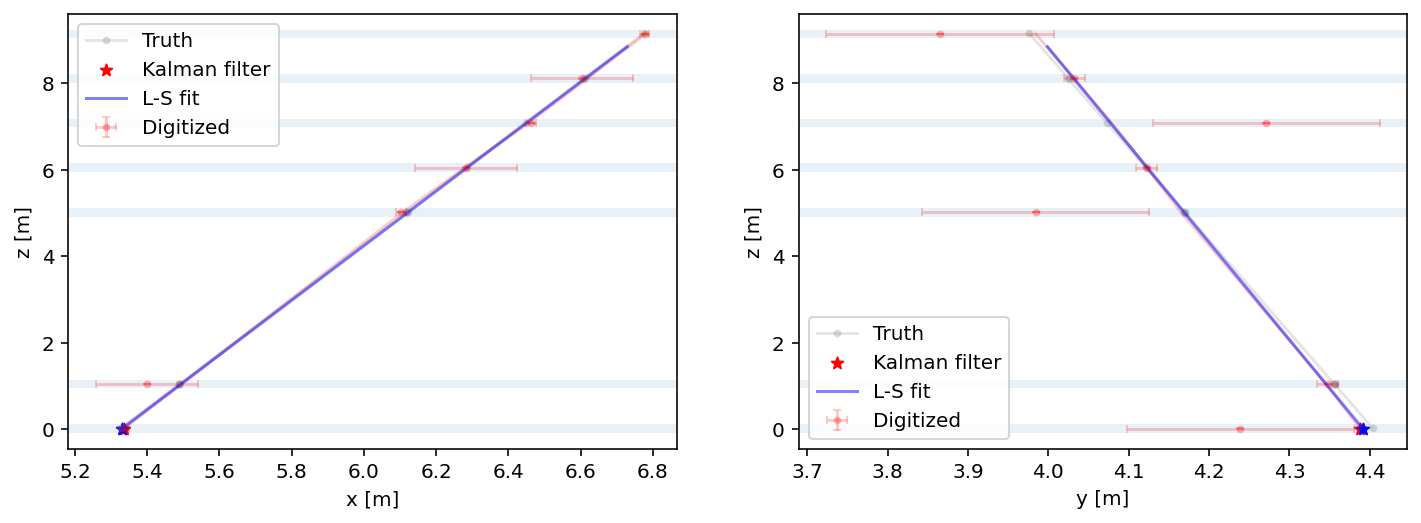

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  10


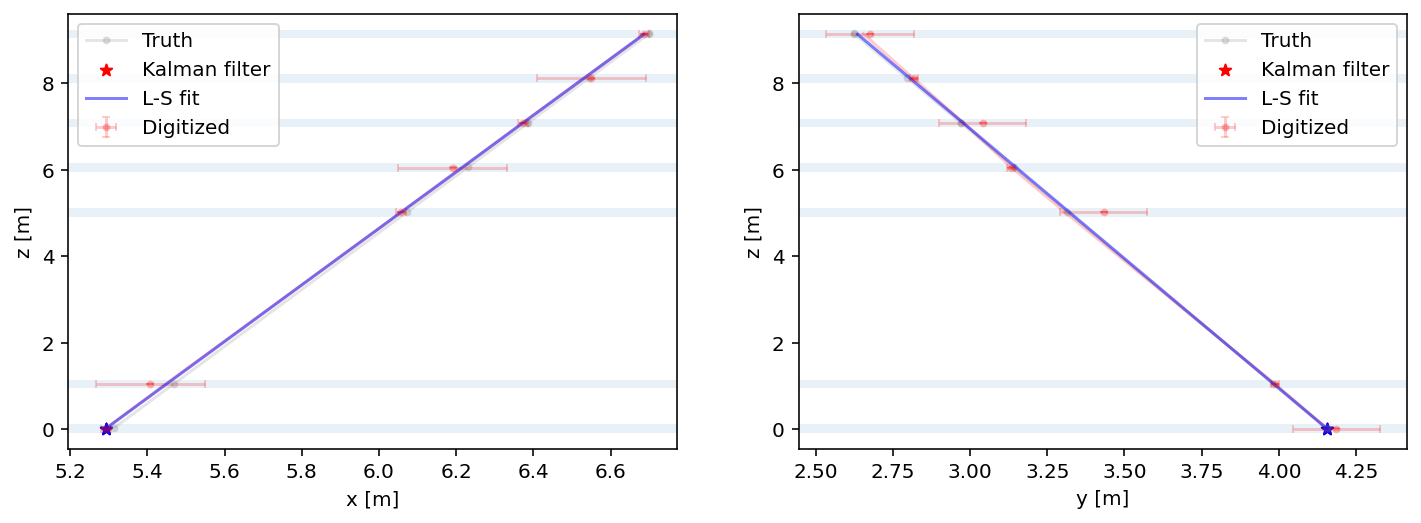

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  15


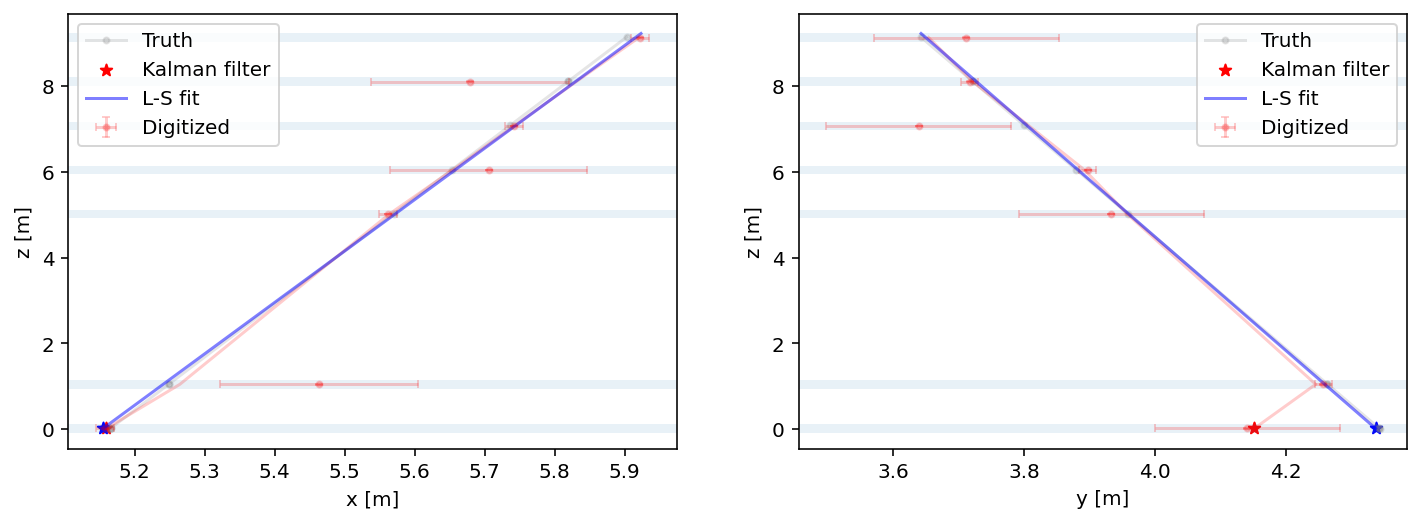

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


Event number:  17


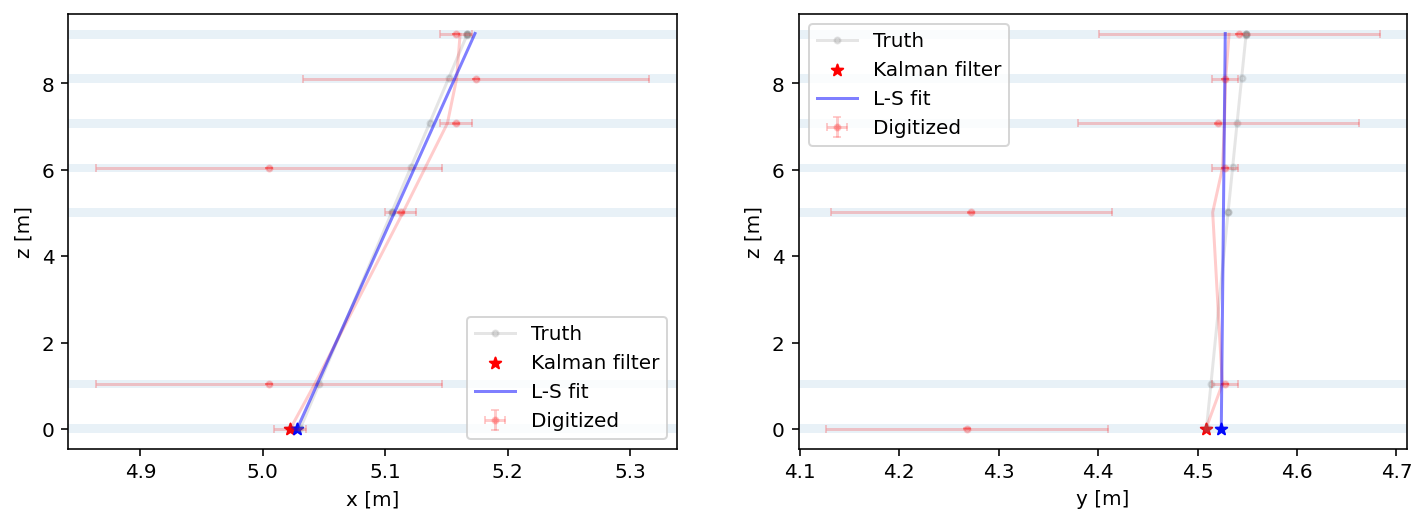

/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser
100%|██████████| 200/200 [12:04<00:00,  3.62s/it]


In [48]:
results_fit={}
results_fit["par_truth"]=[]
results_fit["par_fit"]=[]
results_fit["par_fit_error"]=[]
results_fit["par_km"]=[]
results_fit["par_km_error"]=[]

MAKE_PLOTS=True
PLOT_MAX=10
nplots=0

for i_file in tqdm(range(len(files))):
# for i_file in tqdm(range(10)):
    filename=files[i_file]
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in range(nevents):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        if len(ev.Tree.Digi_x)==7:
            try:
                par_km =[ev.Tree.Track_k_m_x0[0], ev.Tree.Track_k_m_y0[0], ev.Tree.Track_k_m_z0[0], ev.Tree.Track_k_m_t0[0], ev.Tree.Track_k_m_velX[0], ev.Tree.Track_k_m_velY[0], ev.Tree.Track_k_m_velZ[0]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[0], ev.Tree.Track_k_m_ErrorY0[0], ev.Tree.Track_k_m_ErrorZ0[0], ev.Tree.Track_k_m_ErrorT0[0], ev.Tree.Track_k_m_ErrorVx[0], ev.Tree.Track_k_m_ErrorVy[0], ev.Tree.Track_k_m_ErrorVz[0]]
                xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
                xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])
            except:
                continue

            guess=guess_track(hits)
            fit1=fit_track(hits,guess)
            par_fit=list(fit1.values)
            par_fit_error=list(fit1.errors)
            xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
            xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
            time_seq=np.linspace(0,ev.Tree.Digi_time[-1]-ev.Tree.Hit_time[0],100)

            #truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
            xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))


            results_fit["par_truth"].append(par_truth)
            results_fit["par_fit"].append(par_fit)
            results_fit["par_fit_error"].append(par_fit_error)
            results_fit["par_km"].append(par_km)
            results_fit["par_km_error"].append(par_km_error)

            if MAKE_PLOTS and nplots<PLOT_MAX:
                nplots+=1
                print("Event number: ", ev.EventNumber)
                # Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
                truthtracks=ev.get_truthtrack()
                event_vis = ev.get_recon_kalman()

                # Plot x-z, y-z separately
                fig,axs=plt.subplots(1,2,figsize=(12,4))
                xlabels=["x [m]", "y [m]"]
                for i_axis in [0,1]:
                    # Plot truth tracks
                    if len(truthtracks)>0:
                        for track in truthtracks:
                            track=util.coord_cms2det(track)
                            axs[i_axis].plot(track[i_axis],track[2],marker=".",color="grey",alpha=0.2,label="Truth")

                    # Plot reconstructed tracks
                    for i_track in range(len(event_vis["track_nonvertex"])):
                        # Read the reconstructed track
                        track=event_vis["track_nonvertex"][i_track]
                        track=util.coord_cms2det(np.array(track))
                        hits=[[],[],[]]
                        hits_uncertainty=[[],[],[]]

                        # Read hits of this track
                        for i_hit in range(len(track[0])):
                            hit=event_vis["hit_nonvertex"][i_track][i_hit]
                            hit_layer = cut.in_layer(hit[1])
                            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
                            hit=util.coord_cms2det(np.array(hit))
                            hit_uncertainty=hit_uncertainty[[2,0,1]]
                            for i in range(3):
                                hits[i].append(hit[i])
                                hits_uncertainty[i].append(hit_uncertainty[i])
                        # Plot track and hits
                        axs[i_axis].errorbar(hits[i_axis],hits[2],
                                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".",label="Digitized")
                        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)

                    axs[i_axis].scatter(xyz0_km[i_axis], xyz0_km[2], marker="*",color="r",label="Kalman filter")

                    axs[i_axis].scatter(xyz0_fit[i_axis], xyz0_fit[2], marker="*",color="b",)
                    axs[i_axis].plot(xyz0_fit[i_axis]+xyzV_fit[i_axis]*time_seq/100, 
                                     xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                     color="b",alpha=0.5,label="L-S fit")



                    axs[i_axis].set_xlabel(xlabels[i_axis])
                    axs[i_axis].set_ylabel('z [m]')
                    axs[i_axis].legend()
                    vis.drawdet_xz(axis=axs[i_axis])

                plt.show()
                
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])                

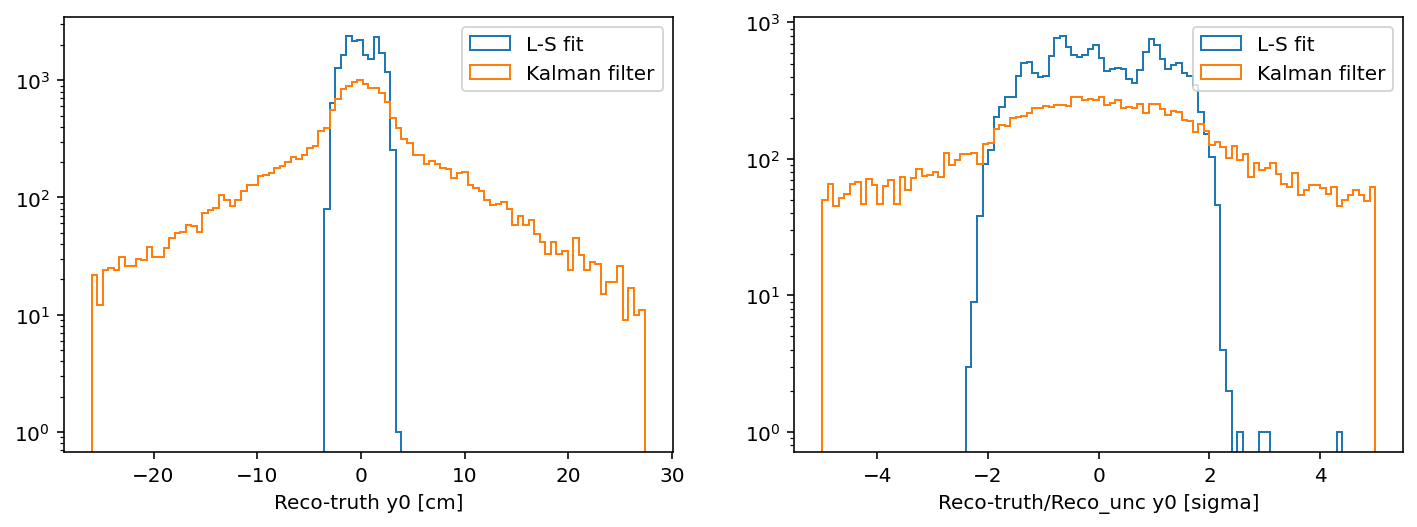

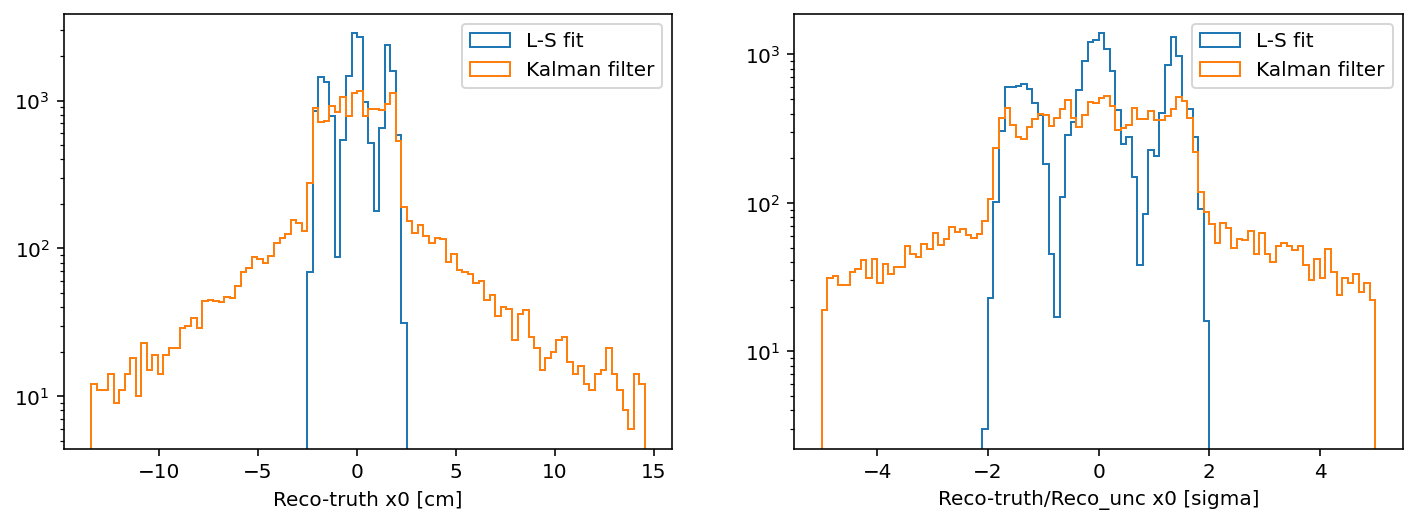

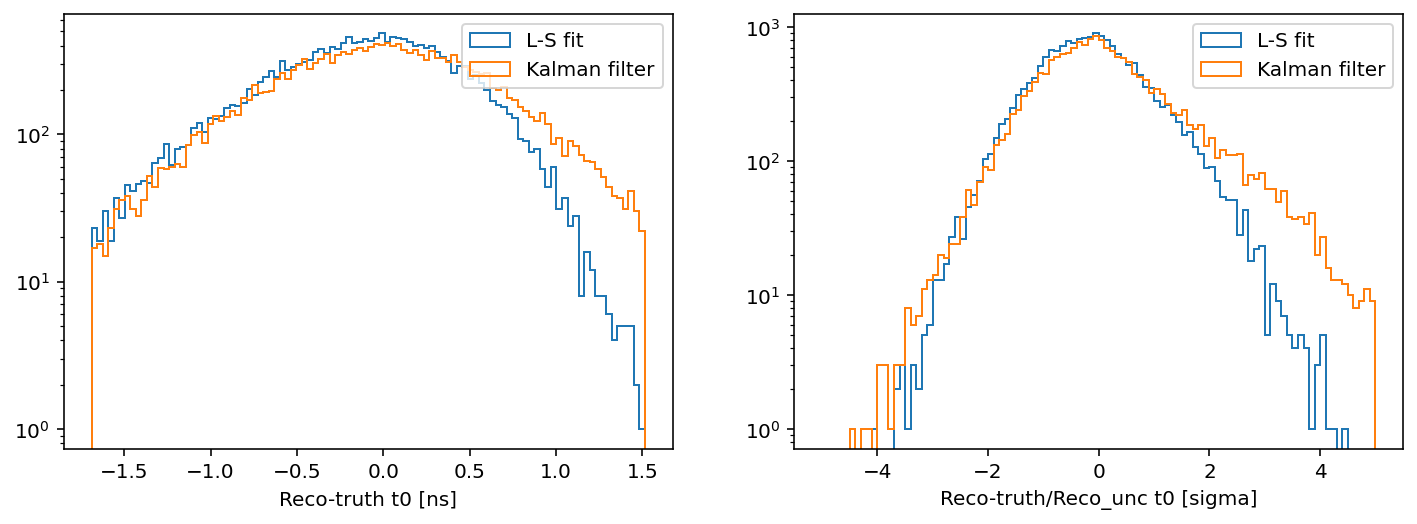

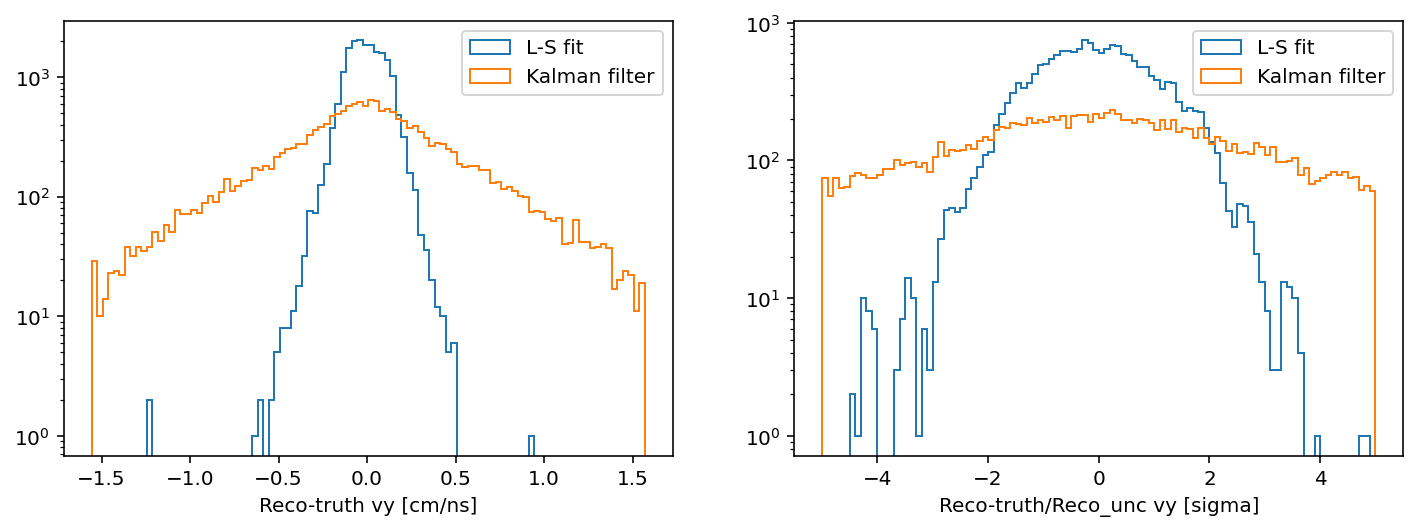

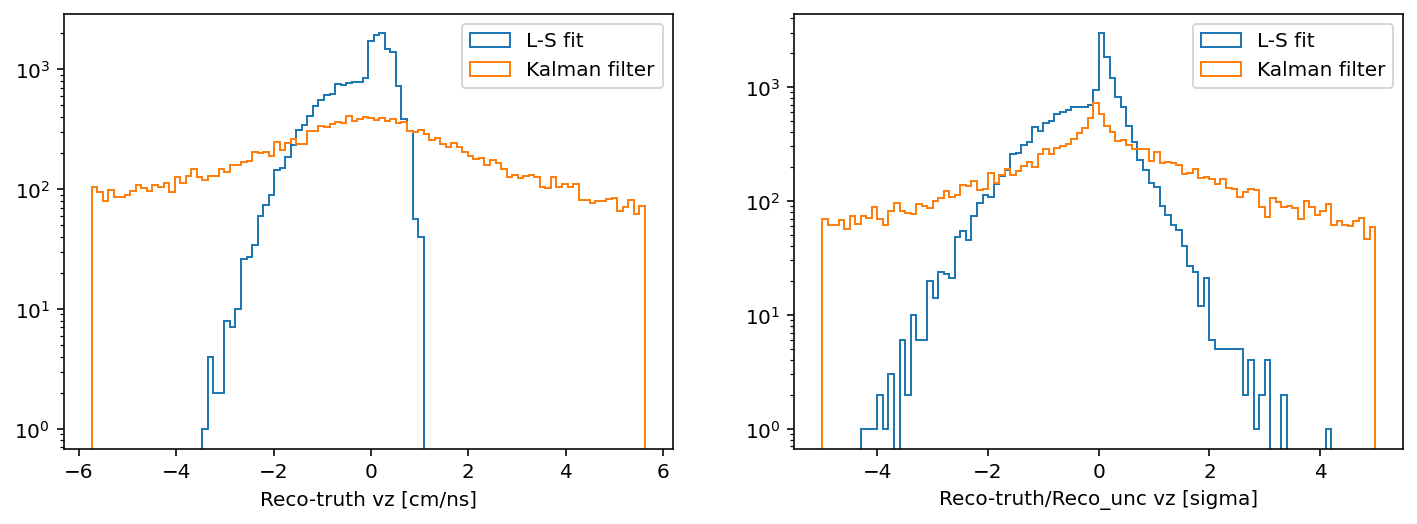

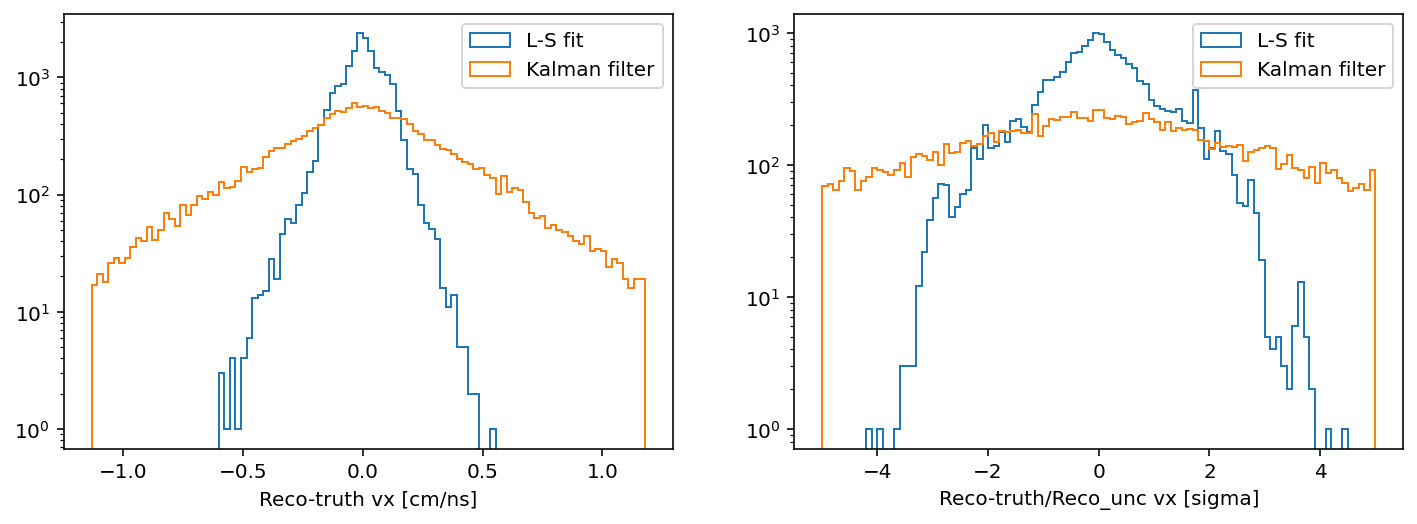

In [49]:
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(7):
    if ipar==1:
        continue
    #_range=ranges[ipar]
    residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
    pull_km=pull(residual_km,0,results_fit["par_fit_error"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar],histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar],histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
    plt.sca(axs[1])
    plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
    plt.yscale("log")    
    
    
    plt.show()

In [31]:
# residual = results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
# mask= residual>20
# print(results_fit["par_truth"][:,3][mask])

In [278]:
results_fit["par_fit"][:,ipar],results_fit["par_truth"][:,ipar]

(array([28.27664635, 29.97924579, 29.92432097, ..., 29.81353626,
        28.7433253 , 29.91908719]),
 array([ -4043.76049898,  -8795.28694436,  -3019.23062178, ...,
        -10539.38440861,  -8153.01210404,  17147.78683445]))

# What events failed?

In [57]:
def get_digi_hits_list(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    hits=[]
    hits_unc=[]
    for ii in range(len(ev.Tree.Digi_y)):
        hit=[ev.Tree.Digi_x[ii], ev.Tree.Digi_y[ii], ev.Tree.Digi_z[ii], ev.Tree.Digi_time[ii]]
        hit_layer = cut.in_layer(hit[1])
        hit_uncertainty = detector.Layer().uncertainty(hit_layer)
        hits.append(hit)
        hits_unc.append(hit_uncertainty)
    return np.array(hits),np.array(hits_unc)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


0
Event number:  0


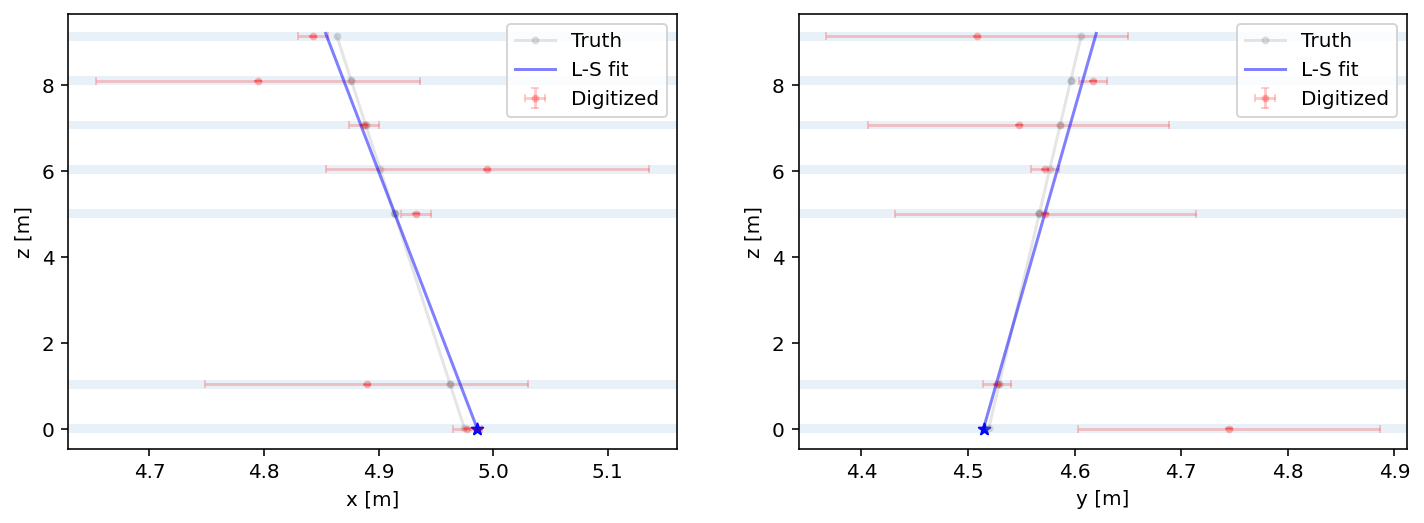

13
Event number:  13


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


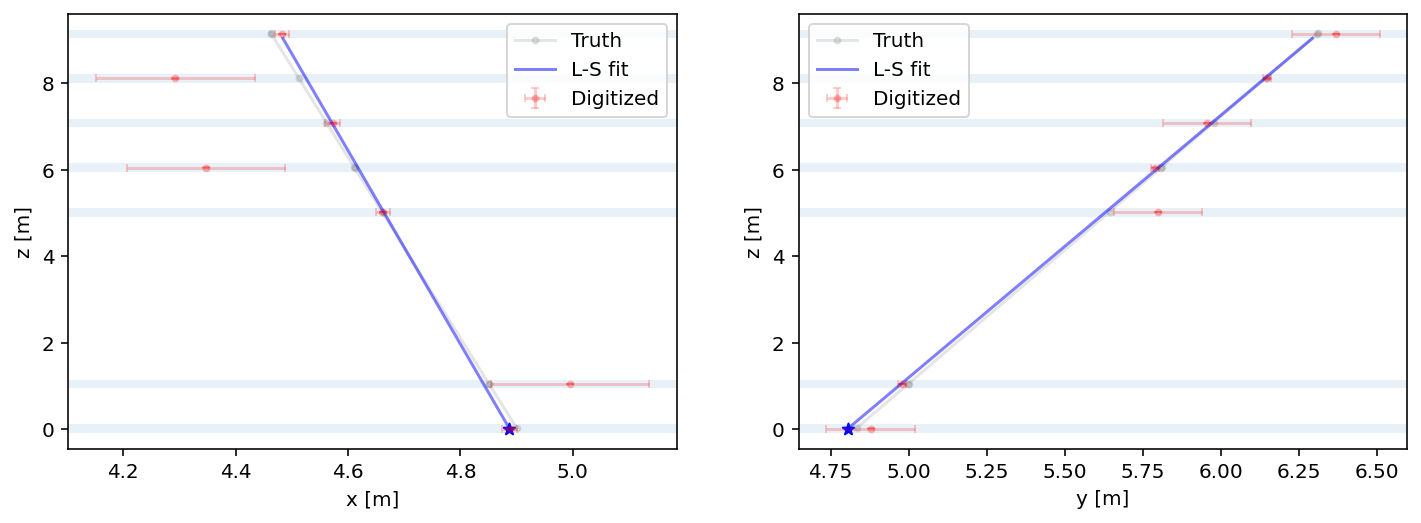

14
Event number:  14


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


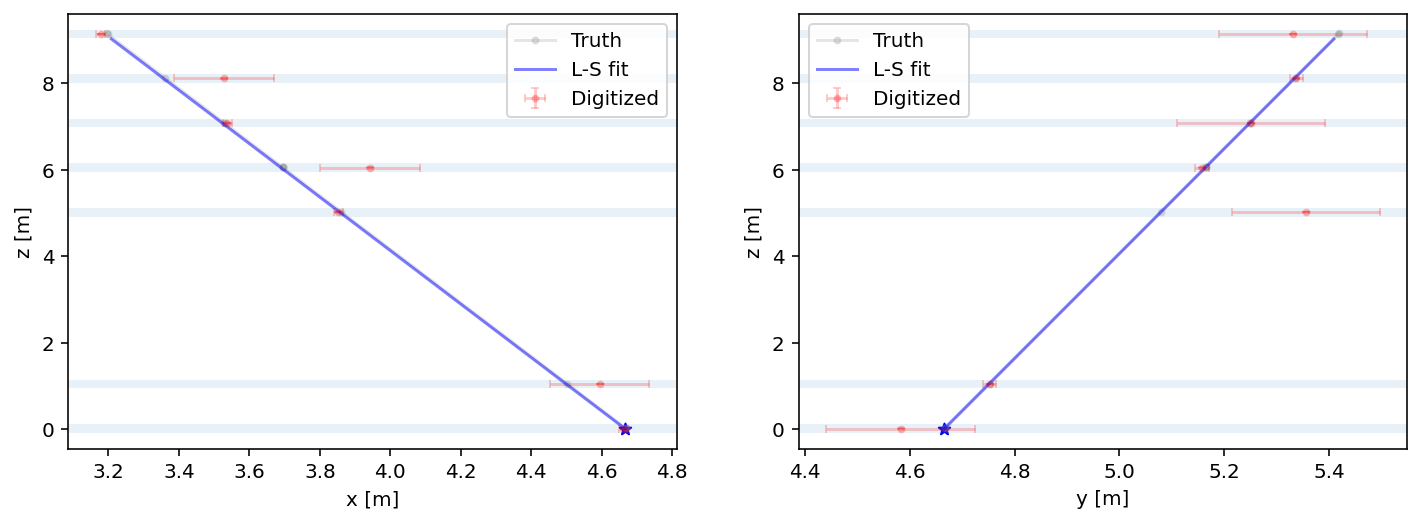

22
Event number:  22


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


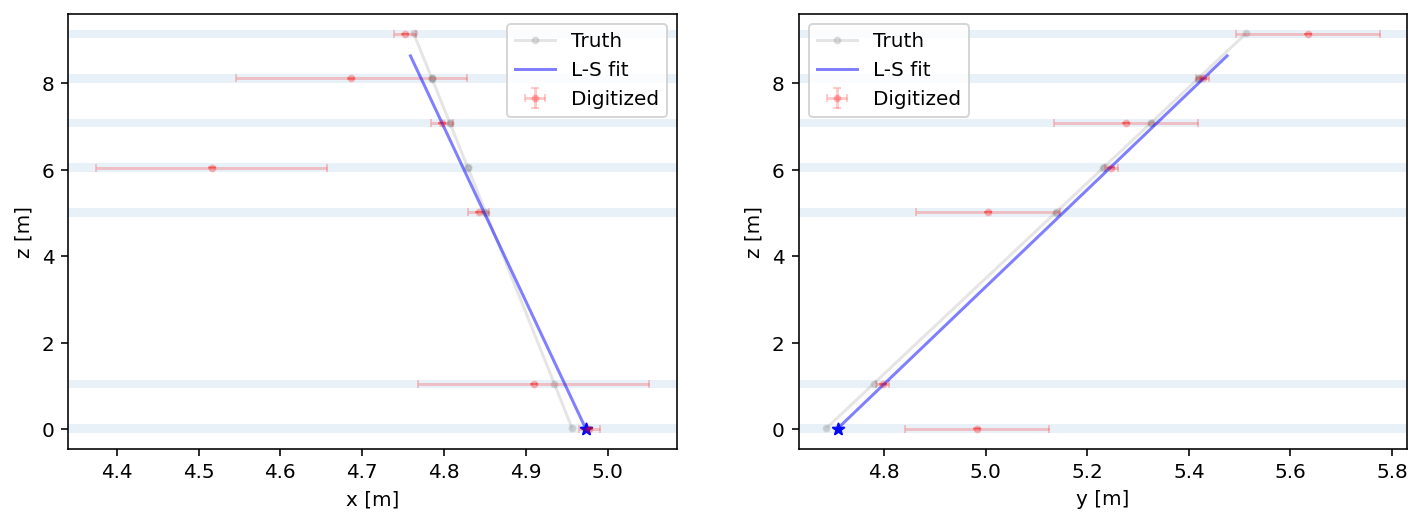

39
Event number:  39


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


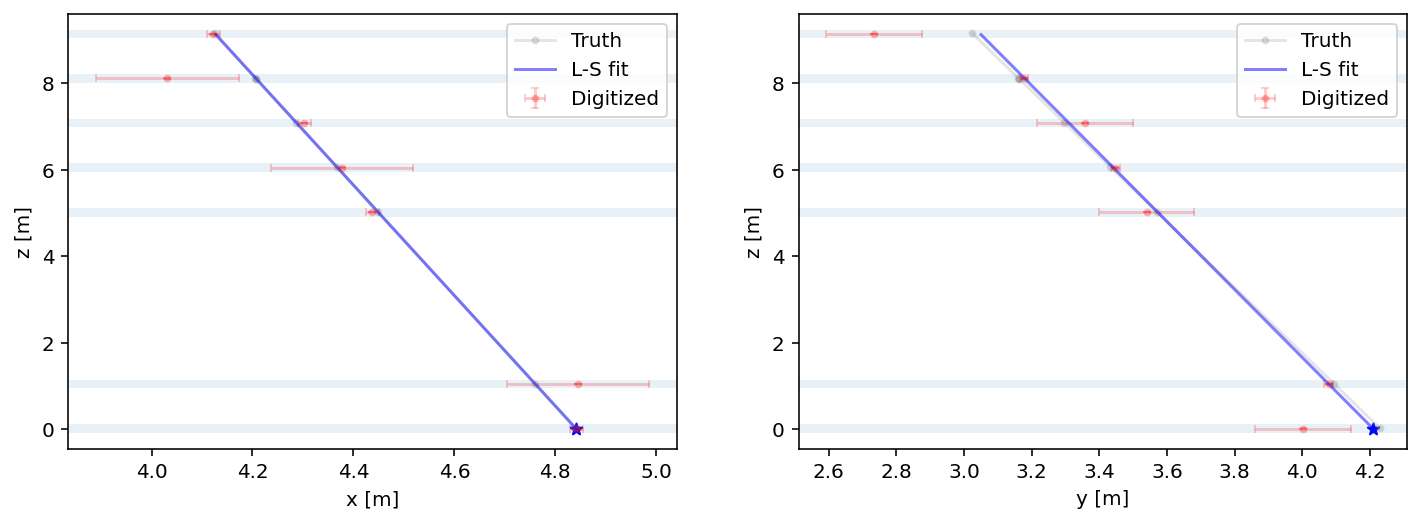

51
Event number:  51


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


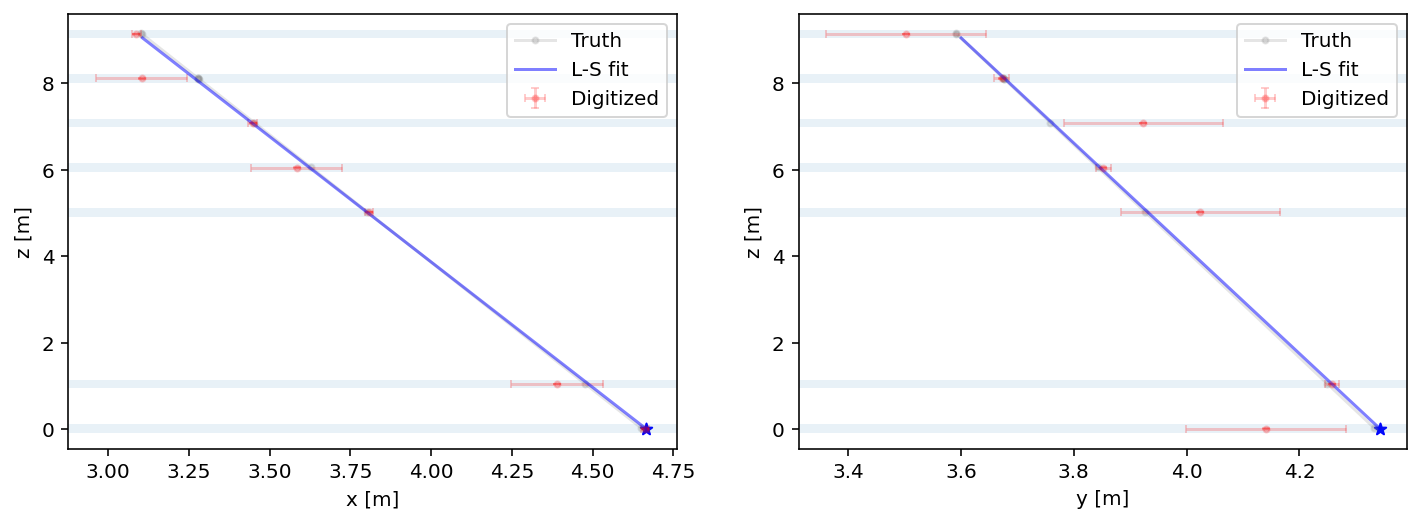

55
Event number:  55


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


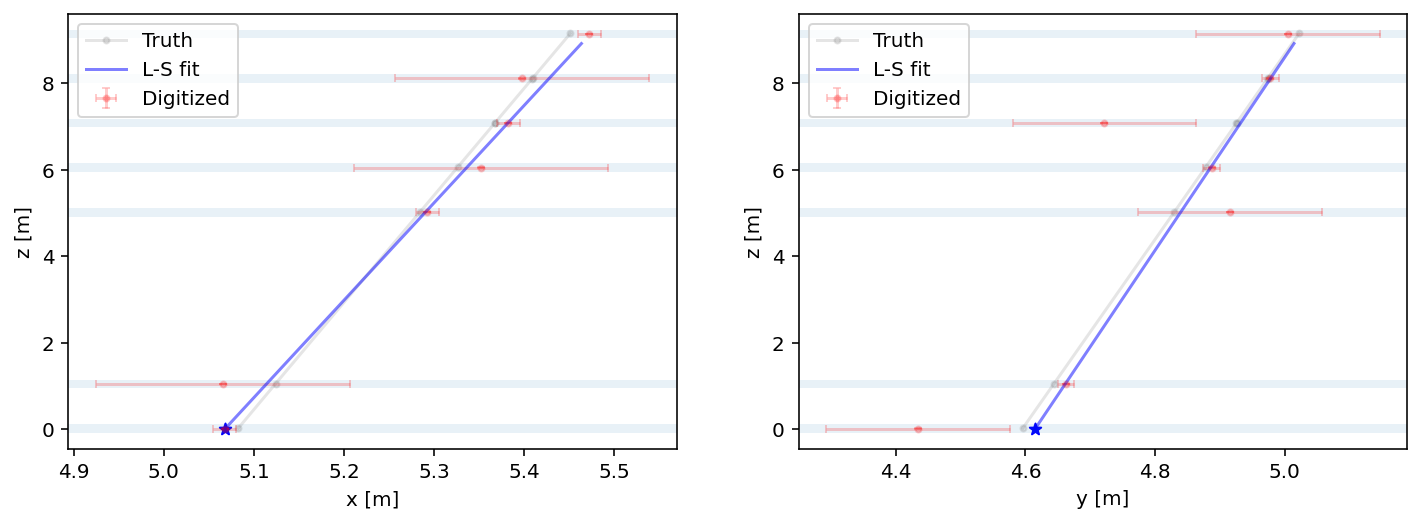

58
Event number:  58


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


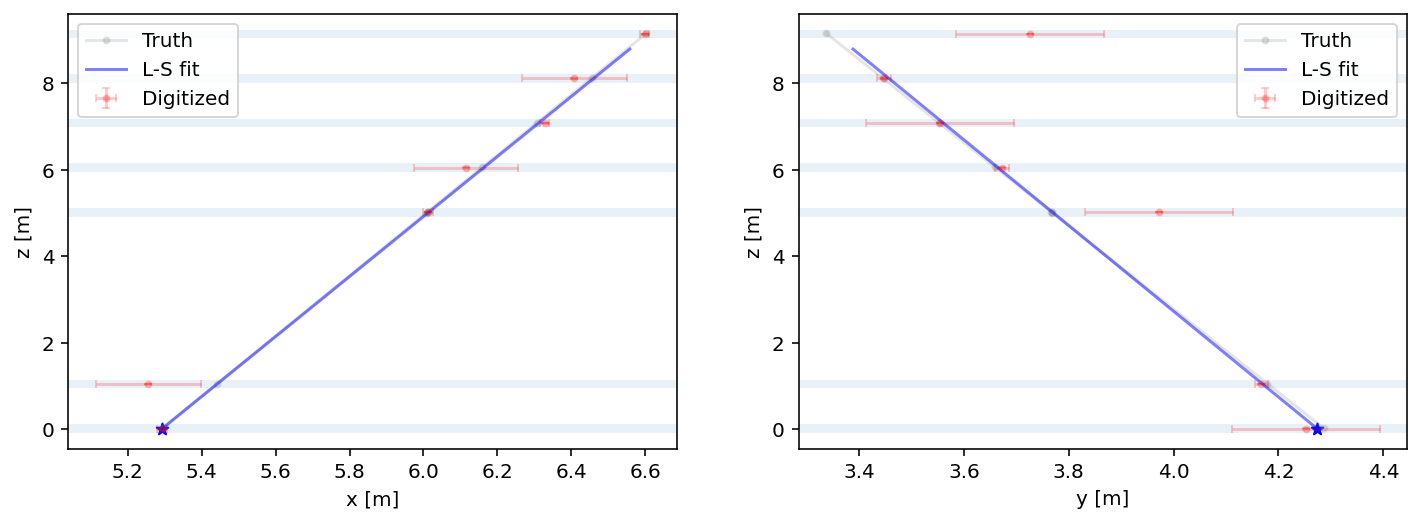

64
Event number:  64


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


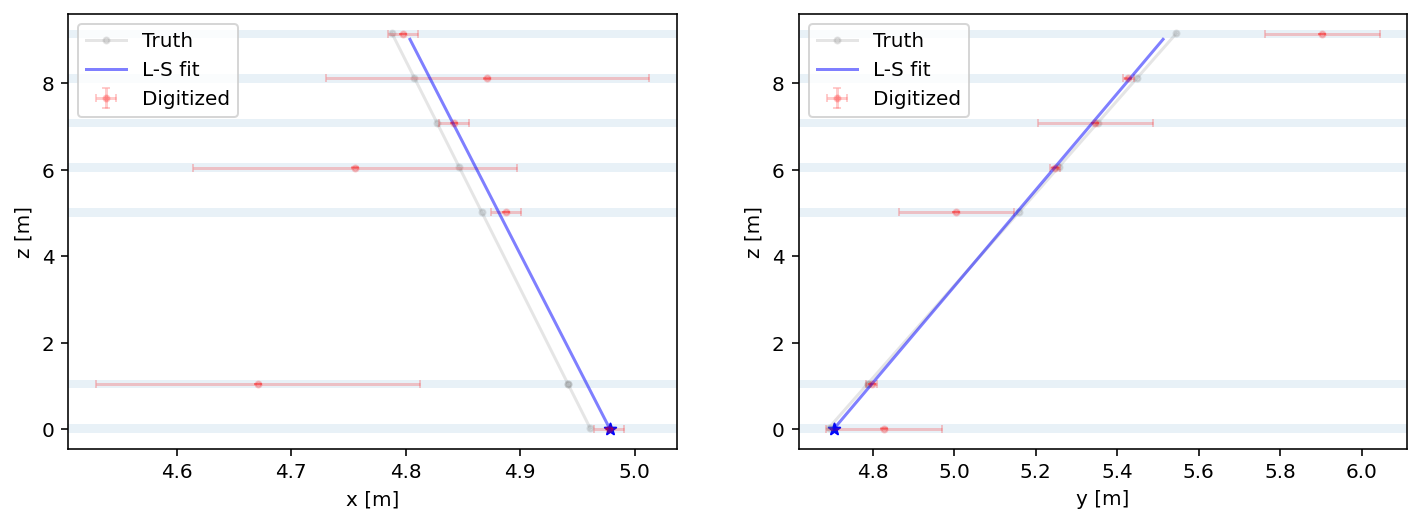

65
Event number:  65


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


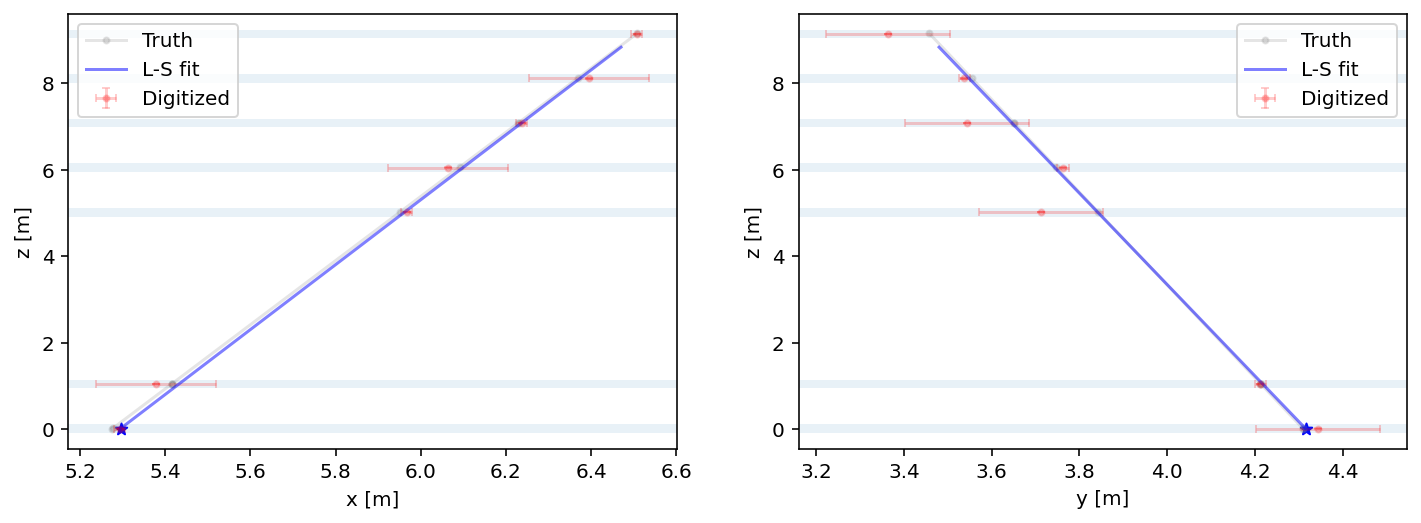

66
Event number:  66


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


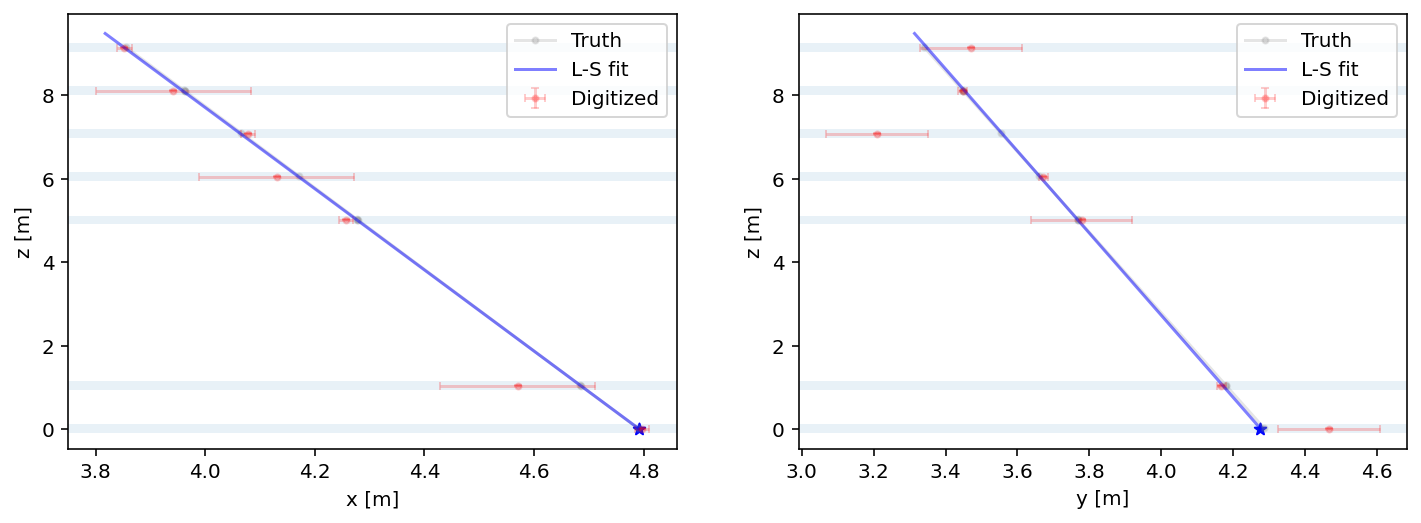

93
Event number:  93


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


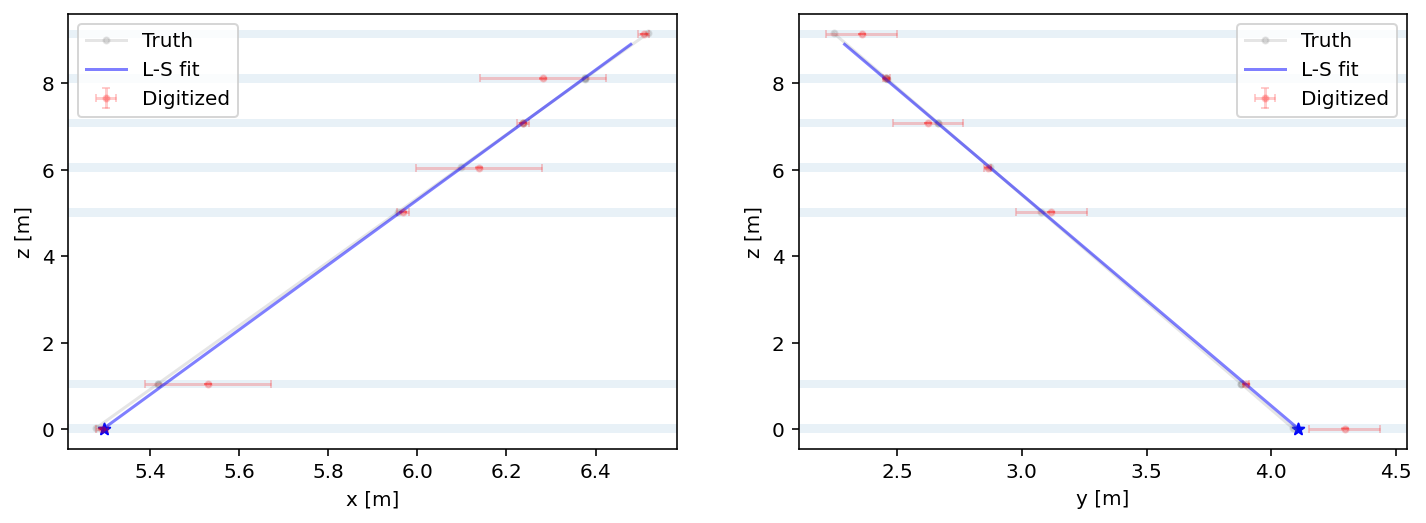

108
Event number:  108


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


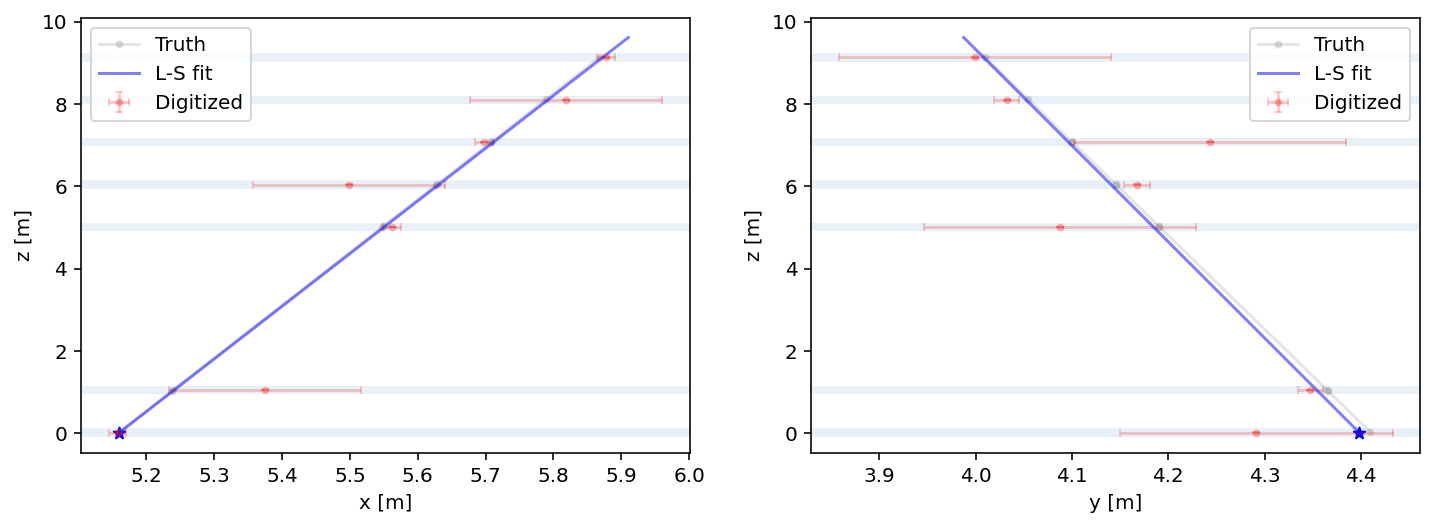

119
Event number:  119


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


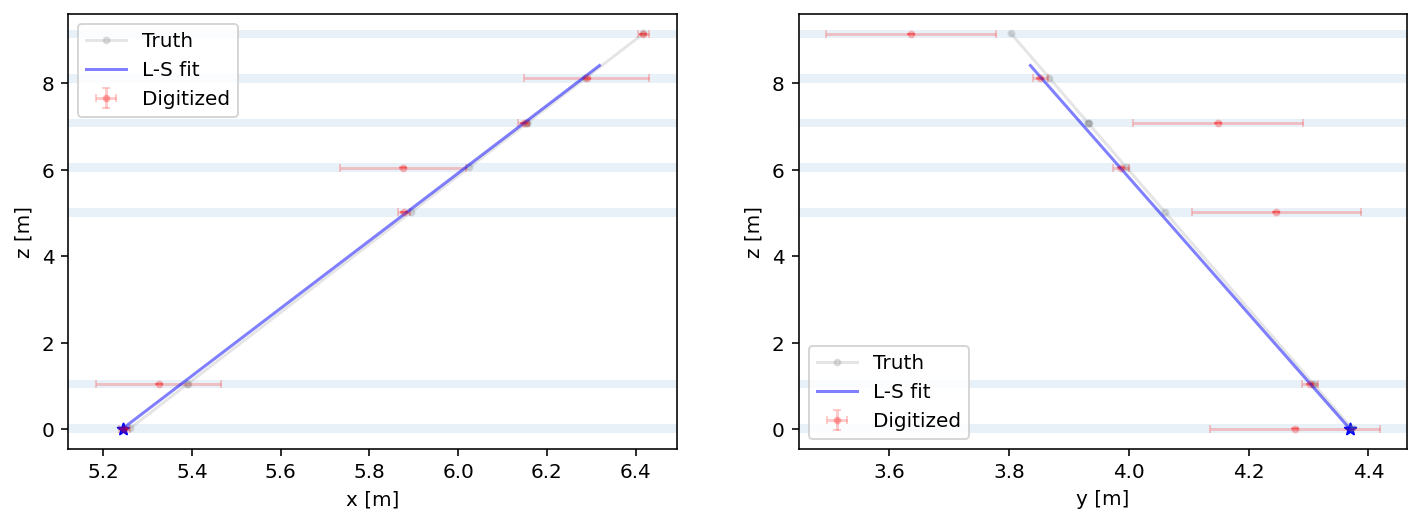

137
Event number:  137


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


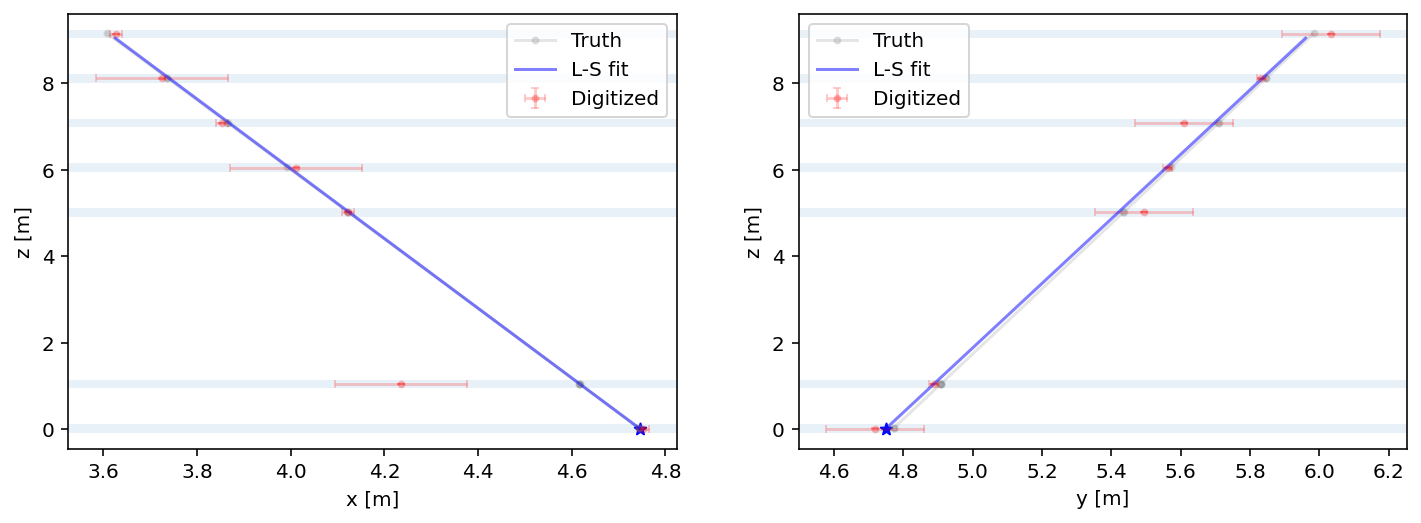

143
Event number:  143


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


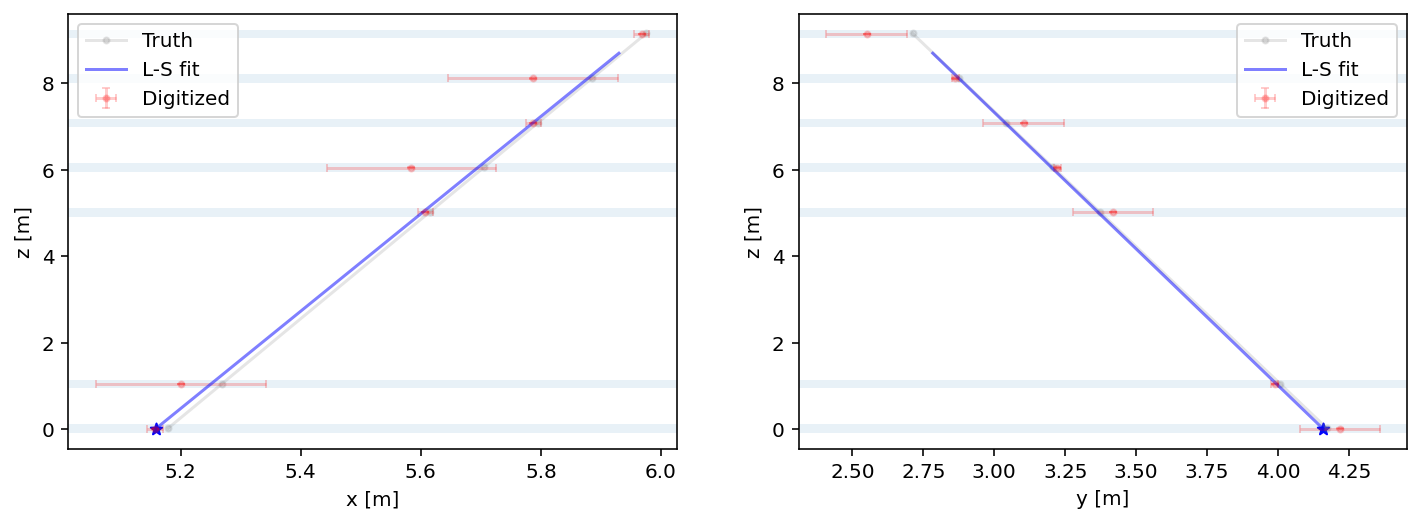

146
Event number:  146


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


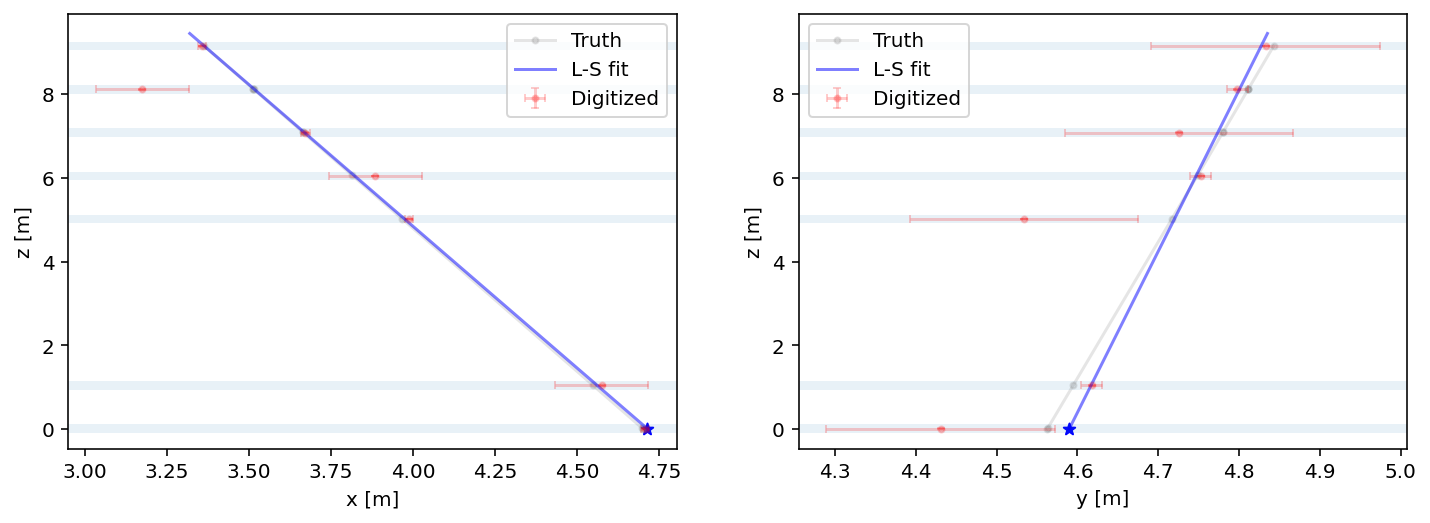

162
Event number:  162


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


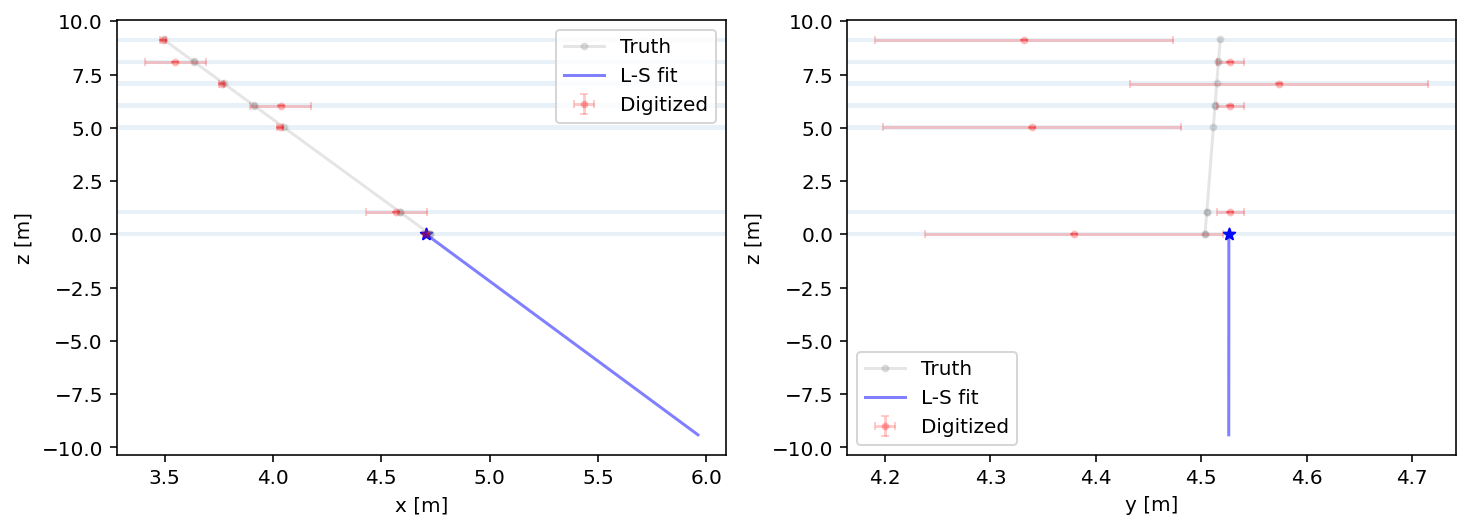

165
Event number:  165


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


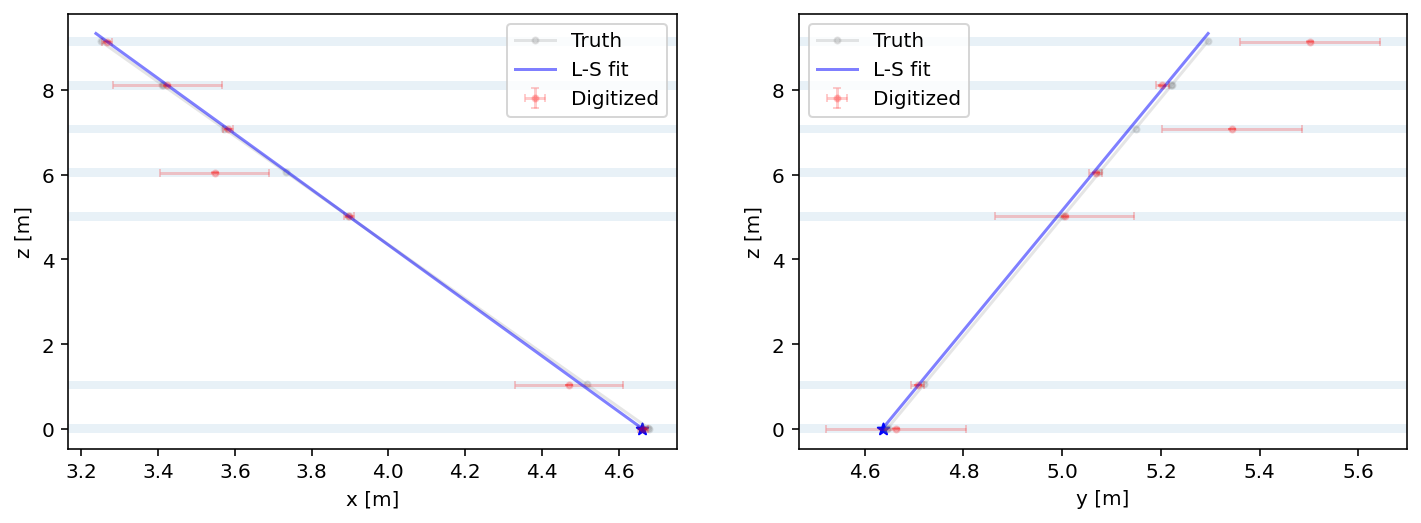

166
Event number:  166


/tmp/ipykernel_14186/1351414192.py:82: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


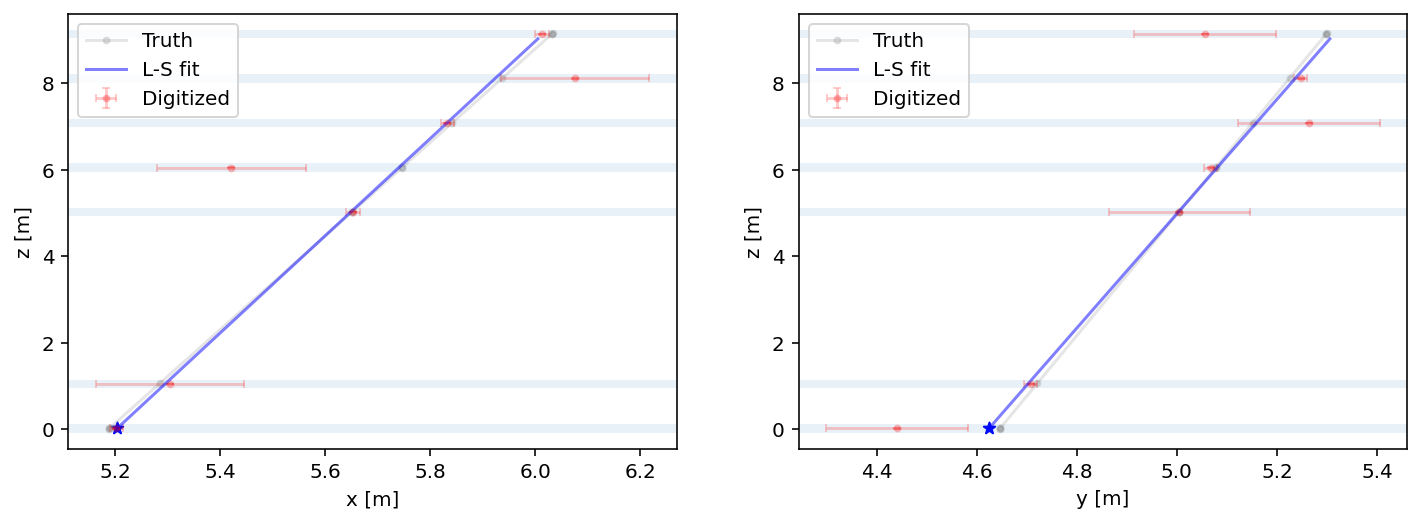

100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


In [72]:
# results_fit={}
# results_fit["par_truth"]=[]
# results_fit["par_fit"]=[]
# results_fit["par_fit_error"]=[]
# results_fit["par_km"]=[]
# results_fit["par_km_error"]=[]

MAKE_PLOTS=True
PLOT_MAX=40
nplots=0

# for i_file in tqdm(range(len(files))):
for i_file in tqdm(range(1)):
    filename=files[i_file]
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    # ev.EventNumber=4
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")



    for i_event in range(nevents):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        if len(ev.Tree.Digi_x)==7:
            try:
                par_km =[ev.Tree.Track_k_m_x0[0], ev.Tree.Track_k_m_y0[0], ev.Tree.Track_k_m_z0[0], ev.Tree.Track_k_m_t0[0], ev.Tree.Track_k_m_velX[0], ev.Tree.Track_k_m_velY[0], ev.Tree.Track_k_m_velZ[0]]
                par_km_error =[ev.Tree.Track_k_m_ErrorX0[0], ev.Tree.Track_k_m_ErrorY0[0], ev.Tree.Track_k_m_ErrorZ0[0], ev.Tree.Track_k_m_ErrorT0[0], ev.Tree.Track_k_m_ErrorVx[0], ev.Tree.Track_k_m_ErrorVy[0], ev.Tree.Track_k_m_ErrorVz[0]]
                xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
                xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])
                continue
            except:
                print(ev.EventNumber)
                pass

            guess=guess_track(hits)
            fit1=fit_track(hits,guess)
            par_fit=list(fit1.values)
            par_fit_error=list(fit1.errors)
            xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
            xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
            time_seq=np.linspace(0,ev.Tree.Digi_time[-1]-ev.Tree.Hit_time[0],100)

            #truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
            Tree=ev.Tree
            dt=Tree.Hit_time[1]-Tree.Hit_time[0]
            vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
            vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
            vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
            par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
            xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))
            
            hits,hits_unc = get_digi_hits_list(ev)
            for i in range(len(hits)):
                hits[i]=np.concatenate((util.coord_cms2det(hits[i][:3]),[0]))
                hits_unc[i]=np.array([hits_unc[i][2],hits_unc[i][0],hits_unc[i][1]])
            hits=hits.T
            hits_unc=hits_unc.T
            


#             results_fit["par_truth"].append(par_truth)
#             results_fit["par_fit"].append(par_fit)
#             results_fit["par_fit_error"].append(par_fit_error)
#             results_fit["par_km"].append(par_km)
#             results_fit["par_km_error"].append(par_km_error)

            if MAKE_PLOTS and nplots<PLOT_MAX:
                nplots+=1
                print("Event number: ", ev.EventNumber)
                # Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
                truthtracks=ev.get_truthtrack()
                event_vis = ev.get_recon_kalman()

                # Plot x-z, y-z separately
                fig,axs=plt.subplots(1,2,figsize=(12,4))
                xlabels=["x [m]", "y [m]"]
                for i_axis in [0,1]:
                    # Plot truth tracks
                    if len(truthtracks)>0:
                        for track in truthtracks:
                            track=util.coord_cms2det(track)
                            axs[i_axis].plot(track[i_axis],track[2],marker=".",color="grey",alpha=0.2,label="Truth")

                    axs[i_axis].errorbar(hits[i_axis],hits[2],
                     xerr=hits_unc[i_axis],yerr=hits_unc[2],
                     color="red",capsize=2,ls='none',alpha=0.2, fmt=".",label="Digitized")


                    axs[i_axis].scatter(xyz0_fit[i_axis], xyz0_fit[2], marker="*",color="b",)
                    axs[i_axis].plot(xyz0_fit[i_axis]+xyzV_fit[i_axis]*time_seq/100, 
                                     xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                                     color="b",alpha=0.5,label="L-S fit")



                    axs[i_axis].set_xlabel(xlabels[i_axis])
                    axs[i_axis].set_ylabel('z [m]')
                    axs[i_axis].legend()
                    vis.drawdet_xz(axis=axs[i_axis])

                plt.show()
                
for key in results_fit:
    results_fit[key]=np.array(results_fit[key])                

In [69]:
ev.EventNumber

199

In [ ]:
 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k_m_z0', 'Track_k_m_t0', 'Track_k_m_ErrorT0', 'Track_k_m_ErrorX0', 'Track_k_m_ErrorY0', 'Track_k_m_ErrorZ0', 'Track_k_m_ErrorVx', 'Track_k_m_ErrorVy', 'Track_k_m_ErrorVz', 'Track_k_m_cov_x_t', 'Track_k_m_cov_x_z', 'Track_k_m_cov_x_vx', 'Track_k_m_cov_x_vy', 'Track_k_m_cov_x_vz', 'Track_k_m_cov_t_z', 'Track_k_m_cov_t_vx', 'Track_k_m_cov_t_vy', 'Track_k_m_cov_t_vz', 'Track_k_m_cov_z_vx', 'Track_k_m_cov_z_vy', 'Track_k_m_cov_z_vz', 'Track_k_m_cov_vx_vy', 'Track_k_m_cov_vx_vz', 'Track_k_m_cov_vy_vz', 'Track_k_m_beta', 'Track_k_m_beta_err', 'Track_k_m_filterchi', 'Track_k_m_smoothchi', 'Track_k_m_smooth_chi_sum', 'x_estimates_m', 'y_estimates_m', 'z_estimates_m', 'NumTracks_k_m', 'Track_k_m_numHits', 'Track_k_m_hitIndices'

In [71]:
ev.EventNumber=166
ev.Tree.GetEntry(166)
print(ev.Tree.Track_k_m_x0),print(ev.Tree.Track_k_m_filterchi)

{}
{}


(None, None)

---
# Vertex study

1. Make a root file that have two tracks per event, by randomly combining existing muon gun events
2. Run tracker

In [11]:
# Start with the 100 GeV sim, make a new copy of the simulation and delect tracker result
# !cp -rf /project/def-mdiamond/tomren/mathusla/data/fit_study/muon_100_GeV /project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV 
# !rm -rf /project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV/*/*/stat*.root

# Make another 100 GeV sim
# simulation -j2 -o /project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV -q -s muon_gun_tom_range.mac energy 100 count 200

# Run Tracker
# tracker /project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV/run0_mod.root /project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [71]:
muon_energy = 100 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/vertex_muon_{muon_energy}_GeV/*/*/run*.root",)
files=util.Utils.sortByExt(files)
print(files,"\n")

# 2. Open one file and print branches
tfile = root.TFile.Open(files[0])
Tree = tfile.Get("box_run")

tfile1 = root.TFile.Open(files[1])
Tree1 = tfile1.Get("box_run")

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

['/project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV/20230129/191525/run0.root', '/project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV/20230130/141123/run0.root'] 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Hit_weight', 'NumGenParticles', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_status', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mo1', 'GenParticle_mo2', 'GenParticle_dau1', 'GenParticle_dau2', 'GenParticle_mass', 'GenParticle_pt', 'GenParticle_eta', 'GenParticle_phi', 'COSMIC_EVENT_ID', 'COSMIC_CORE_X', 'COSMIC_CORE_Y', 'COSMIC_GEN_PRIMARY_ENERGY', 'COSMIC_GEN_THETA', 'COSMIC_GEN_PHI', 'COSMIC_GEN_FIRST_HEIGHT', 'COSMIC_GE

In [ ]:
from array import array

In [84]:
keys = ['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Hit_weight']
keys_nonused=['NumGenParticles', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_status', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mo1', 'GenParticle_mo2', 'GenParticle_dau1', 'GenParticle_dau2', 'GenParticle_mass', 'GenParticle_pt', 'GenParticle_eta', 'GenParticle_phi', 'COSMIC_EVENT_ID', 'COSMIC_CORE_X', 'COSMIC_CORE_Y', 'COSMIC_GEN_PRIMARY_ENERGY', 'COSMIC_GEN_THETA', 'COSMIC_GEN_PHI', 'COSMIC_GEN_FIRST_HEIGHT', 'COSMIC_GEN_ELECTRON_COUNT', 'COSMIC_GEN_MUON_COUNT', 'COSMIC_GEN_HADRON_COUNT', 'COSMIC_GEN_PRIMARY_ID', 'EXTRA_11', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15']
# for key in keys:
#     exec(f"print(type(Tree.{key}))")

f=root.TFile("/project/def-mdiamond/tomren/mathusla/data/fit_study/vertex_muon_100_GeV/run0_mod.root",'RECREATE')
f.cd()
t_fill=root.TTree("box_run","box_run")

# Basic type branch (float) - use array of length 1
NumHits = array('d', [Tree.NumHits])
t_fill.Branch('NumHits', NumHits, 'NumHits/D')
# std::vector branch
for key in keys[1:]:
    exec(f"{key} = root.std.vector('double')(300*[0])")
    exec(f"t_fill.Branch(key, {key})")
    
for key in keys_nonused:
    exec(f"{key} = root.std.vector('double')(1*[0])")
    exec(f"t_fill.Branch(key, {key})")    


for ii in range(nevents):
    Tree.GetEntry(ii)
    Tree1.GetEntry(ii)
    NumHits[0]=Tree.NumHits+Tree1.NumHits
    for key in keys[1:]:
        for j in range(int(Tree.NumHits)):
            exec(f"{key}[j] = Tree.{key}[j]")
        for j in range(int(Tree1.NumHits)):
            exec(f"{key}[j+int(Tree.NumHits)] = Tree1.{key}[j]")     
    t_fill.Fill()
t_fill.Write()

f.Write()
f.Close()

In [65]:
# # a=root.std.vector('double')(300*[0])
# # # a[:51]=list(Tree.Hit_energy)
# # a=root.std.vector('double')(list(Tree.Hit_energy))

# f=root.TFile("run0_mod.root",'RECREATE')
# f.cd()
# t_fill=root.TTree(tree_name,tree_name)

# a=root.std.vector('double')(300*[0])
# t_fill.Branch("a", a)


# # a=root.std.vector('double')([1,2,3,4,5])
# a[:5]=root.std.vector('double')([1,2,3,4,5])
# t_fill.Fill()
# t_fill.Write()

# f.Write()
# f.Close()


---
### Backup, read one file

In [185]:
# 1. filename
muon_energy = 100 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)
filename = files[-1]
# filename='../../simdata/fit_study/run0.root'
# print(files)
print(filename,"\n")

# 2. Open one file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_100_GeV/20230129/191525/stat200.root 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 

## Plot multiple truth tracks

(-1.0, 11.0)

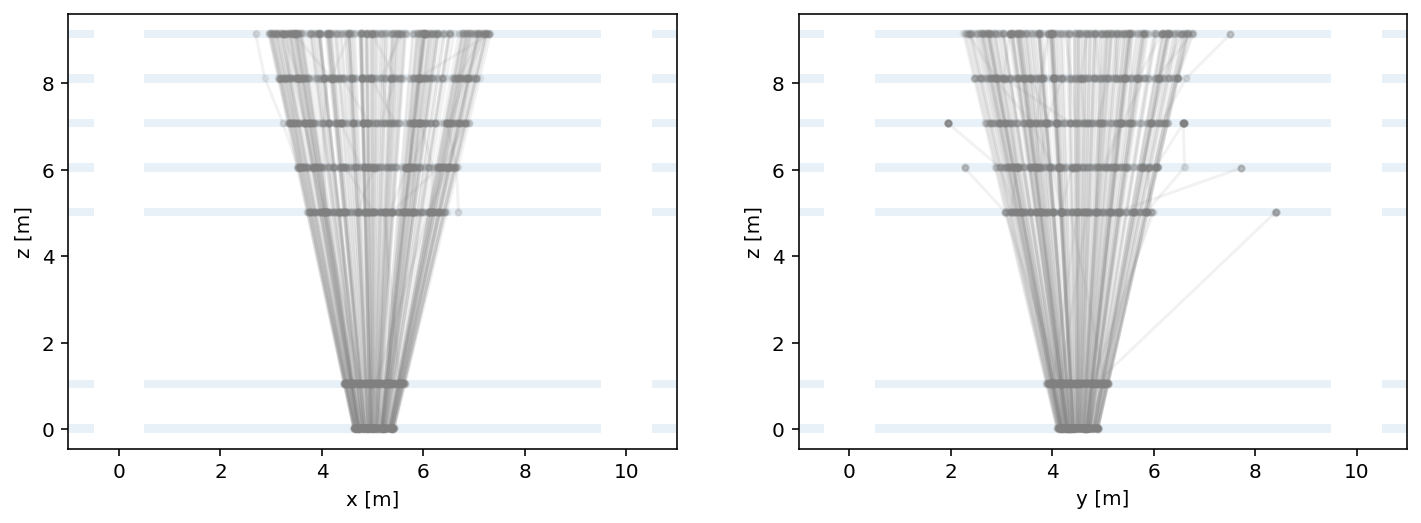

In [9]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]

for i in range(nevents):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            axs[0].plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            axs[1].plot(track[1],track[2],marker=".",color="grey",alpha=0.1)    
    
vis.drawdet_xz(axis=axs[0])
vis.drawdet_xz(axis=axs[1])

axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[1].set_xlabel('y [m]')
axs[1].set_ylabel('z [m]')
axs[0].set_xlim(-1,11)
axs[1].set_xlim(-1,11)

## Plot one track with its Kalman filter reconstruction

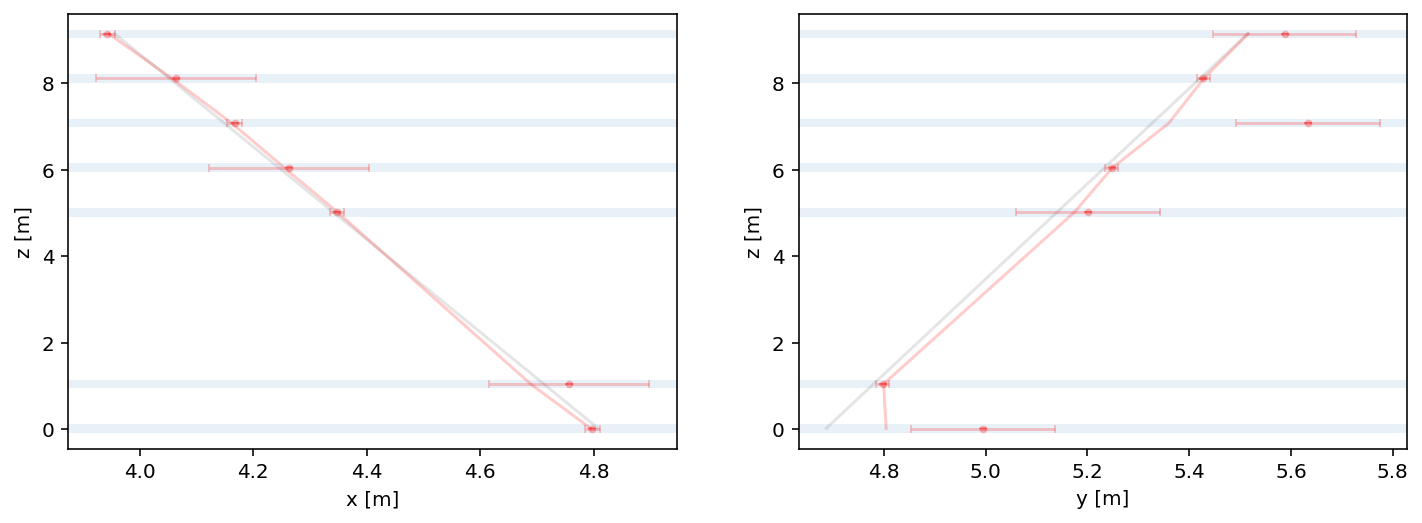

In [186]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=6
cut=cutflow.sample_space("")

# Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

# Plot x-z, y-z separately
fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]
for i_axis in [0,1]:
    # Plot truth tracks
    if len(truthtracks)>0:
        for track in truthtracks:
            track=util.coord_cms2det(track)
            axs[i_axis].plot(track[i_axis],track[2],color="grey",alpha=0.2)

    # Plot reconstructed tracks
    for i_track in range(len(event_vis["track_nonvertex"])):
        # Read the reconstructed track
        track=event_vis["track_nonvertex"][i_track]
        track=util.coord_cms2det(np.array(track))
        hits=[[],[],[]]
        hits_uncertainty=[[],[],[]]
        
        # Read hits of this track
        for i_hit in range(len(track[0])):
            hit=event_vis["hit_nonvertex"][i_track][i_hit]
            hit_layer = cut.in_layer(hit[1])
            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
            hit=util.coord_cms2det(np.array(hit))
            hit_uncertainty=hit_uncertainty[[2,0,1]]
            for i in range(3):
                hits[i].append(hit[i])
                hits_uncertainty[i].append(hit_uncertainty[i])
        # Plot track and hits
        axs[i_axis].errorbar(hits[i_axis],hits[2],
                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".")
        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)
        

    axs[i_axis].set_xlabel(xlabels[i_axis])
    axs[i_axis].set_ylabel('z [m]')
    vis.drawdet_xz(axis=axs[i_axis])


In [29]:
# 'Tree.GetEntry(1)
# print(Tree.Track_k_m_x0), print(Tree.Hit_x[0]),print(Tree.Track_k_m_y0), print(Tree.Hit_y[0]),Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0','

In [86]:
truth=[]
recon=[]
Entry=1

n_events=0
n_failed=0
# list_failed=[]

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)
    
    for Entry in range(100):
        Tree.GetEntry(Entry)
        try:
            n_events+=1
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0]])
        except:
            n_failed+=1
        #list_failed.append(i)

  0%|          | 0/200 [00:00<?, ?it/s]

In [87]:
n_failed/n_events

0.1803

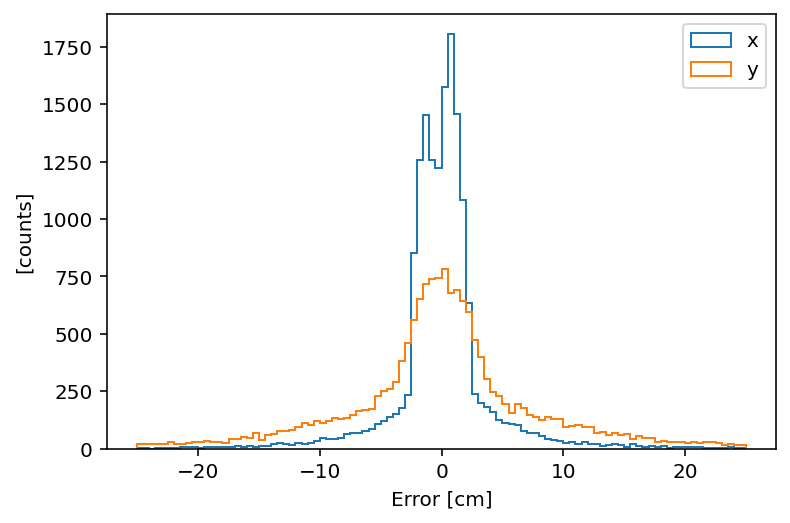

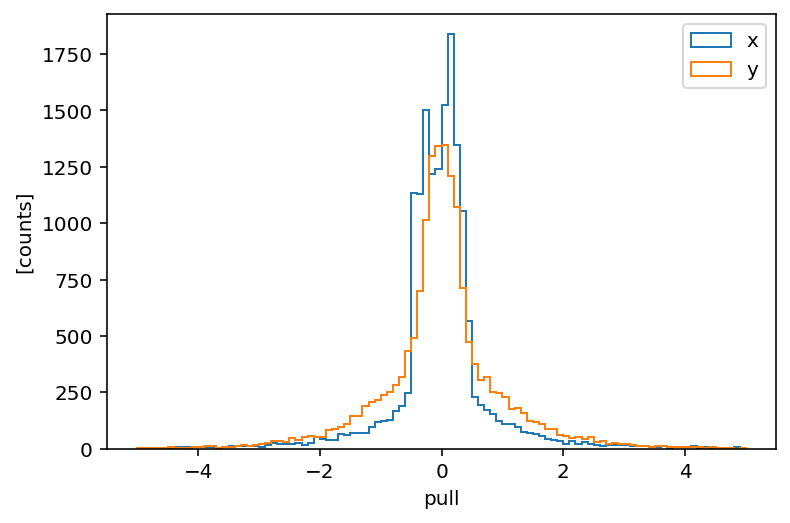

In [97]:
recon=np.array(recon)
truth=np.array(truth)
def pull(x):
    return (x-np.mean(x))/np.std(x)
plt.hist(recon[:,0]-truth[:,0],bins=100,range=(-25,25),histtype="step",label="x0");
plt.hist(recon[:,1]-truth[:,1],bins=100,range=(-25,25),histtype="step",label="y0");

plt.xlabel("Error [cm]")
plt.ylabel("[counts]")
plt.legend()
plt.show()

plt.hist(pull(recon[:,0]-truth[:,0]),bins=100,range=(-5,5),histtype="step",label="x0");
plt.hist(pull(recon[:,1]-truth[:,1]),bins=100,range=(-5,5),histtype="step",label="y0");

plt.xlabel("pull")
plt.ylabel("[counts]")
plt.legend()

In [ ]:
# /gen/pythia/process {process}

# /gen/pythia/cuts/clear
# /gen/pythia/cuts/add 13 | | 0.6:1.9 | -0.695:0.695 rad
# /gen/pythia/cuts/add 14 | | 0.6:1.9 | -0.695:0.695 rad